# Reinforcement Learning Agent for Statistical Arbitrage

This notebook demonstrates how to configure and train a reinforcement learning agent for statistical arbitrage using a snapshot model. The agent will learn to identify and exploit statistical arbitrage opportunities in financial markets.

## Install Packages

The following libraries are required for this notebook. If you haven't installed them yet, you can do so using running the cell below or by using pip install in your terminal.

In [1]:
# Uncomment and install packages once
# %pip -q install -U numpy pandas pyarrow gdown gymnasium stable-baselines3 torch matplotlib tensorboard

## Import Libraries

In [2]:
# ============================================================================
# STANDARD LIBRARY
# ============================================================================
import json                                    # JSON serialization for configs and signals
import math                                    # Mathematical operations (exp, log, sqrt)
import os                                      # File system operations (paths, directories)
import random                                  # Random number generation for seeding
import re                                      # Regular expressions for pattern matching
import gc                                      # Garbage collection for memory management
import tempfile                                # Temporary file management
from datetime import datetime                  # Timestamp handling and formatting
from typing import Optional, Set, Tuple        # Type hints for better code documentation
import hashlib                                 # Hashing
import sys                                     # System-specific parameters and functions
import traceback

# ============================================================================
# SCIENTIFIC COMPUTING & DATA PROCESSING
# ============================================================================
import numpy as np                             # Numerical computing (arrays, tensors)
import pandas as pd                            # Data manipulation (DataFrames, time series)
import pytz                                    # Timezone handling for UTC conversions

# ============================================================================
# VISUALIZATION
# ============================================================================
import matplotlib.pyplot as plt                # Plotting equity curves and metrics

# ============================================================================
# DEEP LEARNING
# ============================================================================
import torch                                   # PyTorch backend for neural networks

# ============================================================================
# REINFORCEMENT LEARNING
# ============================================================================
import gymnasium as gym                        # RL environment interface (OpenAI Gym)
from gymnasium import spaces                   # Action/observation space definitions
from stable_baselines3 import PPO              # Proximal Policy Optimization algorithm
from stable_baselines3.common.callbacks import BaseCallback  # Training callbacks
from stable_baselines3.common.callbacks import CallbackList
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.monitor import Monitor         # Environment monitoring and logging
from stable_baselines3.common.vec_env import DummyVecEnv     # Vectorized environment wrapper
from stable_baselines3.common.utils import get_linear_fn  # Learning rate scheduling

# ============================================================================
# UTILITIES
# ============================================================================
from gdown import download                     # Google Drive file downloads
from IPython.display import display            # Enhanced display for Jupyter notebooks
from tqdm import tqdm                          # Progress bars for long-running operations
import psutil                                  # Memory Monitoring

# ============================================================================
# LOCAL CONFIGURATION
# ============================================================================
from config import CONFIG                      # Project-specific settings and hyperparameters


print("✓ All imports loaded successfully.\n")

✓ All imports loaded successfully.



Gym has been unmaintained since 2022 and does not support NumPy 2.0 amongst other critical functionality.
Please upgrade to Gymnasium, the maintained drop-in replacement of Gym, or contact the authors of your software and request that they upgrade.
Users of this version of Gym should be able to simply replace 'import gym' with 'import gymnasium as gym' in the vast majority of cases.
See the migration guide at https://gymnasium.farama.org/introduction/migration_guide/ for additional information.


## Helper Functions

In [3]:
# set annualization factors for different timeframes
ANNUALIZATION = {"1m":365*24*60,
                 "5m":365*24*12,
                 "15m":365*24*4,
                 "1h":365*24,
                 "1d":365}

# create directory if it doesn't already exist
def ensure_dir(path: str):
    os.makedirs(path, exist_ok=True)

## Set Computation Device (Unused)

This section sets the computation device for training the model. It checks if a GPU is available and sets it as the device; otherwise, it defaults to CPU.

In [4]:
# run on cuda GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")

# run on Apple Silicon GPU
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("MPS is available. Using Apple Silicon GPU.")

# run on CPU (slow)
else:
    device = torch.device("cpu")
    print("CUDA and MPS are not available. Using CPU.")

MPS is available. Using Apple Silicon GPU.


## Set Seeds

This section sets the random seeds for various libraries to ensure that the results are reproducible.

Note: It is good practice to type (set data types) for function and method parameters for better code maintainability.

In [5]:
def set_all_seeds(seed: int = 42):
    # seed for random module
    random.seed(seed)

    # seed for numpy module
    np.random.seed(seed)

    try:

        # seed for torch module (CPU)
        torch.manual_seed(seed)

        # seed for CUDA device (GPU)
        if torch.cuda.is_available(): 
            torch.cuda.manual_seed_all(seed)

        # seed for Apple Silicon device (MPS)
        elif torch.backends.mps.is_available():
            torch.backends.mps.manual_seed_all(seed)

    except Exception as e:
        sys.stdout.write("Error setting seeds:")
        sys.stdout.write(f"Exception: {str(e)}")
        sys.stdout.flush()

set_all_seeds(CONFIG["ENV"]["seed"]) # set all seeds for reproducibility

Error setting seeds:Exception: module 'torch.backends.mps' has no attribute 'manual_seed_all'

## Download Feature Data

In this section, we retrieve the .csv file created during feature engineering.

In [6]:
def download_file(file_name: str, file_id: str, out_dir: str):
    ensure_dir(out_dir)

    out_path = os.path.join(out_dir, f"{file_name}.csv")  # full output path

    if os.path.exists(out_path):
        print(f"Skipping download. File {file_name} already exists in cache.")
        return

    try:
        print(f"Downloading {file_name} -> {out_path}")
        url = f"https://drive.google.com/uc?id={file_id}"
        success = download(url, out_path, quiet=False, use_cookies=False, verify=True)
        print("Download complete.")
        return success
    except Exception as e:
        sys.stdout.write(f"Download attempt failed for {file_name}. Error: {str(e)}")
        sys.stdout.flush()
    
# donwload features
file_name = CONFIG["DATA"]["features"]["file_name"]
file_id = CONFIG["DATA"]["features"]["file_id"]
cache_dir = CONFIG["DATA"]["cache_dir"]

success = download_file(file_name, file_id, cache_dir)

Skipping download. File bin_futures_full_features already exists in cache.


## Load Feature Data

Once the data is downloaded, this section loads the data into a pandas DataFrame for later processing.

In [7]:
def load_csv_to_df(
    path: str,
    sep: str = ",",
    timestamp_index_col: str | None = "datetime",
    encoding: str = "utf-8-sig",
    **read_csv_kwargs,
) -> pd.DataFrame:
    """
    Load a CSV into a pandas DataFrame.

    Parameters
    ----------
    path : str
        Filesystem path to the CSV.
    parse_timestamp_col : str | None
        If provided and present in the CSV, this column will be parsed to datetime.
        Set to None to skip datetime parsing.
    **read_csv_kwargs :
        Extra arguments passed to `pd.read_csv` (e.g., sep, dtype, usecols).

    Returns
    -------
    pd.DataFrame
    """

    print("     Loading dataset (ca. 10 seconds)...")

    # Parse header-only to check for timestamp col presence
    head = pd.read_csv(path, sep=sep, encoding=encoding, nrows=0)

    if timestamp_index_col and timestamp_index_col in head.columns:
        read_csv_kwargs = {
            **read_csv_kwargs,
            "parse_dates": [timestamp_index_col],
        }

    df = pd.read_csv(path, sep=sep, encoding=encoding, engine="pyarrow", **read_csv_kwargs)

    df = df.set_index("datetime")

    print("     Datset loaded:")

    return df


# load features
file_name = CONFIG["DATA"]["features"]["file_name"]
cache_dir = CONFIG["DATA"]["cache_dir"]
index = CONFIG["DATA"]["features"]["index"]
sep = CONFIG["DATA"]["features"].get("seperator", ",")
file_path = os.path.join(cache_dir, f"{file_name}.csv")
features_df = load_csv_to_df(file_path, sep, timestamp_index_col=index)

# print dataframe info
print("Features DataFrame Info:")
print(features_df.info())

     Loading dataset (ca. 10 seconds)...
     Datset loaded:
Features DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 525600 entries, 2024-05-01 00:00:00 to 2025-04-30 23:59:00
Columns: 789 entries, AAVE_close to XRP_fundingMinutesLeft
dtypes: float64(763), int64(25), object(1)
memory usage: 3.1+ GB
None


## Identify Feature Structure

In [8]:
def identify_assets_features_pairs(
    df: pd.DataFrame,
    single_asset_format: str,
    pair_feature_format: str,
) -> tuple[list[str], list[str], list[str], list[tuple[str, str]]]:
    """
    Returns distinct
      1. assets
      2. single-asset feature names (ARB_closeUpperShadow → closeUpperShadow)
      3. pair feature names (ARB_ETH_spreadNorm → spreadNorm)
      4. unordered asset pairs
    """

    def format_to_regex(fmt: str) -> re.Pattern:
        escaped = re.escape(fmt)

        def repl(match: re.Match[str]) -> str:
            name = match.group(1)
            char_class = r"[A-Za-z0-9_]+" if "FEATURE" in name.upper() else r"[A-Za-z0-9]+"
            return f"(?P<{name}>{char_class})"

        escaped = re.sub(r"\\\{(\w+)\\\}", repl, escaped)
        return re.compile(f"^{escaped}$")

    single_asset_pattern = format_to_regex(single_asset_format)
    pair_feature_pattern = format_to_regex(pair_feature_format)
    generic_single_pattern = re.compile(r"^(?P<ASSET>[A-Za-z0-9]+)_(?P<FEATURE>[A-Za-z0-9_]+)$")

    assets: Set[str] = set()
    single_features: Set[str] = set()
    pair_features: Set[str] = set()
    pairs: Set[Tuple[str, str]] = set()

    literal_feature = None
    if "{FEATURE}" not in single_asset_format:
        literal_feature = single_asset_format.replace("{ASSET}", "").lstrip("_")

    skip_cols = {"timestamp", "datetime", "date"}

    for col in df.columns:
        if col in skip_cols:
            continue

        match_pair = pair_feature_pattern.match(col)
        if match_pair:
            a1, a2, feat = match_pair.group("ASSET1"), match_pair.group("ASSET2"), match_pair.group("FEATURE")
            assets.update((a1, a2))
            pairs.add(tuple(sorted((a1, a2))))
            pair_features.add(feat)
            continue

        match_single = single_asset_pattern.match(col)
        if match_single:
            asset = match_single.group("ASSET")
            assets.add(asset)
            feat = match_single.groupdict().get("FEATURE") or literal_feature
            if feat:
                single_features.add(feat)
            continue

        match_generic = generic_single_pattern.match(col)
        if match_generic:
            asset, feat = match_generic.group("ASSET"), match_generic.group("FEATURE")
            assets.add(asset)
            single_features.add(feat)
            continue

    return (
        sorted(assets),
        sorted(single_features),
        sorted(pair_features),
        sorted(pairs),
    )

# identify assets, features, and asset pairs
single_asset_format = CONFIG["DATA"]["asset_price_format"]
pair_feature_format = CONFIG["DATA"]["pair_feature_format"]
assets, single_asset_features, pair_features, asset_pairs = identify_assets_features_pairs(
    features_df,
    CONFIG["DATA"]["asset_price_format"],
    CONFIG["DATA"]["pair_feature_format"],
)

print(f"Identified {len(assets)} assets: {assets}")
print(f"Identified {len(single_asset_features)} single-asset features: {single_asset_features}")
print(f"Identified {len(pair_features)} pair features: {pair_features}")
print(f"Identified {len(asset_pairs)} asset pairs: {asset_pairs}")

Identified 25 assets: ['AAVE', 'ADA', 'APT', 'ARB', 'ATOM', 'AVAX', 'BCH', 'BNB', 'BTC', 'DOGE', 'DOT', 'ENA', 'ETC', 'ETH', 'HBAR', 'LINK', 'LTC', 'NEAR', 'SUI', 'TON', 'TRX', 'UNI', 'WLD', 'XLM', 'XRP']
Identified 12 single-asset features: ['close', 'closeBias', 'closeEwmaVol', 'closeKalman', 'closeLowerShadow', 'closeMacd', 'closeRsi', 'closeSigns', 'closeStochRsi', 'closeUpperShadow', 'funding', 'fundingMinutesLeft']
Identified 8 pair features: ['alpha', 'beta', 'corr', 'pval', 'spreadNorm', 'spreadNormKalman', 'spreadNormMa', 'spreadNormVol']
Identified 61 asset pairs: [('AAVE', 'SUI'), ('AAVE', 'TRX'), ('ADA', 'BTC'), ('ADA', 'DOGE'), ('ADA', 'HBAR'), ('ADA', 'LTC'), ('ADA', 'SUI'), ('ADA', 'XLM'), ('ADA', 'XRP'), ('APT', 'AVAX'), ('ARB', 'ATOM'), ('ARB', 'AVAX'), ('ARB', 'DOT'), ('ARB', 'ETC'), ('ARB', 'ETH'), ('ARB', 'NEAR'), ('ARB', 'WLD'), ('ATOM', 'BCH'), ('ATOM', 'DOT'), ('ATOM', 'ENA'), ('ATOM', 'ETC'), ('AVAX', 'BCH'), ('AVAX', 'DOT'), ('AVAX', 'ETC'), ('AVAX', 'UNI'), ('

## Build Time Intervals

In [9]:
def build_time_intervals(
    df: pd.DataFrame,
    window: pd.Timedelta | str,
    step: Optional[pd.Timedelta | str] = None,
    timestamp_col: str = "datetime",
    include_last_partial: bool = False,
) -> list[tuple[pd.Timestamp, pd.Timestamp]]:
    """
    Return fixed-length time intervals over the DataFrame's time span.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain a datetime-like 'timestamp' column or have a DatetimeIndex.
    window : pd.Timedelta | str
        Size of each window, e.g. '2D', '60min', '15T'.
    step : pd.Timedelta | str | None
        Step between consecutive window starts. Defaults to `window` (non-overlapping).
        Use a smaller step than `window` for sliding/overlapping windows.
    timestamp_col : str
        Name of the timestamp column (ignored if index is a DatetimeIndex).
    include_last_partial : bool
        If True, include the trailing partial window shorter than `window`.

    Returns
    -------
    list[tuple[pd.Timestamp, pd.Timestamp]]
        Half-open intervals [start, end).
    """
    W = pd.Timedelta(window)
    S = pd.Timedelta(step) if step is not None else W

    # Extract, sanitize, and sort timestamps
    if timestamp_col in df.columns:
        ts = pd.to_datetime(df[timestamp_col]).dropna().sort_values()
    elif isinstance(df.index, pd.DatetimeIndex):
        ts = pd.Series(df.index).dropna().sort_values()
    else:
        raise ValueError(
            f"Timestamp column '{timestamp_col}' not found and index is not DatetimeIndex."
        )

    intervals: list[tuple[pd.Timestamp, pd.Timestamp]] = []
    if ts.empty:
        return intervals

    t_min = ts.iloc[0]
    t_max = ts.iloc[-1]
    cur = t_min

    while cur < t_max:
        end = cur + W
        if end <= t_max:
            intervals.append((cur, end))
        elif include_last_partial:
            intervals.append((cur, t_max))
            break
        else:
            break
        cur = cur + S

    return intervals

# build intervals
window = CONFIG["ENV"]["trading_window_days"]
step = CONFIG["ENV"]["sliding_window_step"]
timestamp_col = CONFIG["DATA"]["timestamp_col"]

intervals = build_time_intervals(
    features_df,
    window,
    step,
    timestamp_col,
    include_last_partial=False
)

# print interval info
print(f"Built {len(intervals)} time intervals with window={window} and step={step}.")
print("First 3 intervals:")
for start, end in intervals[:3]:
    print(f"  {start} to {end}")

Built 364 time intervals with window=1D and step=1D.
First 3 intervals:
  2024-05-01 00:00:00 to 2024-05-02 00:00:00
  2024-05-02 00:00:00 to 2024-05-03 00:00:00
  2024-05-03 00:00:00 to 2024-05-04 00:00:00


## Identify Feature Time Intervals

In [10]:
def is_timeframe_valid(
    df: pd.DataFrame,
    pair: tuple[str, str],
    start: pd.Timestamp,
    end: pd.Timestamp,
    feature_name: str,
    pair_feature_format: str = "{ASSET1}_{ASSET2}_{FEATURE}",
    timestamp_col: str | None = "datetime",
) -> bool:
    """
    Check if the given time frame has complete data for the specified asset pair.

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing the data.
    pair : tuple[str, str]
        Asset pair (asset1, asset2).
    start : pd.Timestamp
        Start of the time frame (inclusive).
    end : pd.Timestamp
        End of the time frame (exclusive).
    pair_feature_format : str
        Format string for pair-feature columns (e.g., "{ASSET1}_{ASSET2}_{FEATURE}").
    timestamp_col : str
        Name of the timestamp column.

    Returns
    -------
    bool
        True if the time frame is valid (no missing data), False otherwise.
    """
    feature_col = pair_feature_format.format(
        ASSET1=pair[0], ASSET2=pair[1], FEATURE=feature_name
    )

    if timestamp_col and timestamp_col in df.columns:
        ts = df[timestamp_col]
    else:
        if not isinstance(df.index, pd.DatetimeIndex):
            raise ValueError(
                "DataFrame neither has the timestamp column nor a DatetimeIndex."
            )
        ts = df.index

    mask = (ts >= start) & (ts < end)
    if mask.sum() == 0:
        return False

    data_slice = df.loc[mask, feature_col]
    return not data_slice.isna().any()


pair_identifier = CONFIG["DATA"]["features"]["pair_identifier"]

valid_intervals_per_pair = {}
for pair in asset_pairs:
    valid_intervals = []
    for start, end in intervals:
        if is_timeframe_valid(
            features_df,
            pair,
            start,
            end,
            feature_name=pair_identifier,
            pair_feature_format=pair_feature_format,
            timestamp_col=timestamp_col):

            valid_intervals.append((start, end))
    valid_intervals_per_pair[pair] = valid_intervals

    print(f"Pair {pair} has {len(valid_intervals)} valid intervals out of {len(intervals)} total intervals.")
print(f"Total valid intervals: {sum(len(v) for v in valid_intervals_per_pair.values())}")

Pair ('AAVE', 'SUI') has 19 valid intervals out of 364 total intervals.
Pair ('AAVE', 'TRX') has 6 valid intervals out of 364 total intervals.
Pair ('ADA', 'BTC') has 27 valid intervals out of 364 total intervals.
Pair ('ADA', 'DOGE') has 33 valid intervals out of 364 total intervals.
Pair ('ADA', 'HBAR') has 54 valid intervals out of 364 total intervals.
Pair ('ADA', 'LTC') has 31 valid intervals out of 364 total intervals.
Pair ('ADA', 'SUI') has 22 valid intervals out of 364 total intervals.
Pair ('ADA', 'XLM') has 30 valid intervals out of 364 total intervals.
Pair ('ADA', 'XRP') has 35 valid intervals out of 364 total intervals.
Pair ('APT', 'AVAX') has 35 valid intervals out of 364 total intervals.
Pair ('ARB', 'ATOM') has 32 valid intervals out of 364 total intervals.
Pair ('ARB', 'AVAX') has 35 valid intervals out of 364 total intervals.
Pair ('ARB', 'DOT') has 39 valid intervals out of 364 total intervals.
Pair ('ARB', 'ETC') has 60 valid intervals out of 364 total intervals.


## Feature Panel Creation

In [11]:
def print_memory_usage():
    """Print current memory usage in GB, MB, and percentage of total system memory."""
    process = psutil.Process()
    mem_info = process.memory_info()
    mem_gb = mem_info.rss / 1024**3
    mem_mb = mem_info.rss / 1024**2
    
    # Get total system memory
    total_mem = psutil.virtual_memory().total
    total_gb = total_mem / 1024**3
    mem_percent = (mem_info.rss / total_mem) * 100
    
    print(f"💾 Current Memory Usage: {mem_gb:.2f} GB ({mem_mb:.1f} MB) - {mem_percent:.1f}% of {total_gb:.1f} GB total")
    return mem_gb

print_memory_usage()

💾 Current Memory Usage: 4.51 GB (4616.1 MB) - 28.2% of 16.0 GB total


4.5078887939453125

In [12]:
def create_feature_panel(
    df: pd.DataFrame,
    assets: list[str],
    single_asset_features: list[str],
    pair_features: list[str],
    asset_pairs: list[tuple[str, str]],
    pair_feature_format: str,
    timestamp_col: str | None = "datetime",
) -> pd.DataFrame:
    """Assemble a MultiIndex feature panel from pre-normalized inputs."""
    if timestamp_col and timestamp_col in df.columns:
        working_df = df.set_index(timestamp_col)
    else:
        working_df = df
        if not isinstance(working_df.index, pd.DatetimeIndex):
            raise ValueError(
                "DataFrame needs either `timestamp_col` or a DatetimeIndex in order to build the panel."
            )

    # Ensure index is timezone-aware UTC from the start
    if working_df.index.tz is None:
        working_df.index = working_df.index.tz_localize('UTC')
    elif working_df.index.tz != pytz.UTC:
        working_df.index = working_df.index.tz_convert('UTC')

    panel_columns: list[tuple[str, str]] = []
    panel_series: list[pd.Series] = []

    for asset in assets:
        for feature in single_asset_features:
            col_name = f"{asset}_{feature}"
            if col_name in working_df.columns:
                panel_series.append(working_df[col_name])
                panel_columns.append((asset, feature))

    for asset1, asset2 in asset_pairs:
        for feature in pair_features:
            col_name = pair_feature_format.format(
                ASSET1=asset1, ASSET2=asset2, FEATURE=feature
            )
            if col_name in working_df.columns:
                panel_series.append(working_df[col_name])
                panel_columns.append((f"{asset1}_{asset2}", feature))

    if not panel_series:
        raise ValueError("No matching feature columns found to construct the panel.")

    panel = pd.concat(panel_series, axis=1)
    panel.columns = pd.MultiIndex.from_tuples(panel_columns, names=["asset", "feature"])
    return panel.fillna(0)


# Create feature panel
print_memory_usage()
panel = create_feature_panel(
    features_df,
    assets,
    single_asset_features,
    pair_features,
    asset_pairs,
    CONFIG["DATA"]["pair_feature_format"],
)

print("Feature panel structure:")
print("\nShape:", panel.shape)
print("\nSample of the data:")
print(panel.head())

# Delete features_df to free memory after panel creation
print("\n🧹 Cleaning up intermediate variables...")
del features_df
gc.collect()
print_memory_usage()

💾 Current Memory Usage: 4.51 GB (4617.8 MB) - 28.2% of 16.0 GB total
Feature panel structure:

Shape: (525600, 788)

Sample of the data:
asset                          AAVE                                     \
feature                       close closeBias closeEwmaVol closeKalman   
datetime                                                                 
2024-05-01 00:00:00+00:00  4.423169       0.0          0.0         0.0   
2024-05-01 00:01:00+00:00  4.422809       0.0          0.0         0.0   
2024-05-01 00:02:00+00:00  4.421368       0.0          0.0         0.0   
2024-05-01 00:03:00+00:00  4.422929       0.0          0.0         0.0   
2024-05-01 00:04:00+00:00  4.422569       0.0          0.0         0.0   

asset                                                                     \
feature                   closeLowerShadow closeMacd closeRsi closeSigns   
datetime                                                                   
2024-05-01 00:00:00+00:00              0.0

4.9815826416015625

## Feature scaling and state tensor construction

This section normalizes the features and constructs the state tensors required for training the reinforcement learning agent. State tensors are multi-dimensional arrays that represent the current state of the environment that the RL agent uses to make decisions.

In [13]:
def generate_config_hash():
    """Generate a hash from the current tensor build configuration."""
    config_dict = {
        "lookback_window": CONFIG["ENV"]["lookback_window"],
        "splits": CONFIG["SPLITS"],
        "data_sampling": CONFIG["DATA"].get("sampling", "1m"),
        "single_asset_features": sorted(CONFIG["DATA"]["features"].get("single_asset", [])),
        "pair_features": sorted(CONFIG["DATA"]["features"].get("pair", [])),
        "asset_pairs": sorted([f"{a1}_{a2}" for a1, a2 in asset_pairs]),
        "intervals": intervals,
    }
    
    # Convert to JSON string for consistent hashing
    config_str = json.dumps(config_dict, sort_keys=True, default=str)
    config_hash = hashlib.md5(config_str.encode()).hexdigest()[:12]
    
    return config_hash, config_dict

def validate_cache_config(metadata):
    """Check if cached tensors match current configuration."""
    current_hash, current_config = generate_config_hash()
    cached_hash = metadata.get('config_hash', None)
    
    if cached_hash is None:
        print("⚠️  Cache has no config hash (old version) - recommend rebuild")
        return False
    
    if current_hash != cached_hash:
        print("⚠️  Configuration mismatch detected!")
        print(f"   Cached config hash: {cached_hash}")
        print(f"   Current config hash: {current_hash}")
        
        # Show differences
        cached_config = metadata.get('config', {})
        differences = []
        
        if cached_config.get('lookback_window') != current_config['lookback_window']:
            differences.append(f"  • Lookback: {cached_config.get('lookback_window')} → {current_config['lookback_window']}")
        
        if cached_config.get('data_sampling') != current_config['data_sampling']:
            differences.append(f"  • Sampling: {cached_config.get('data_sampling')} → {current_config['data_sampling']}")
        
        cached_features = set(cached_config.get('single_asset_features', []))
        current_features = set(current_config['single_asset_features'])
        if cached_features != current_features:
            differences.append(f"  • Features changed: {len(cached_features)} → {len(current_features)}")
        
        if differences:
            print("   Key differences:")
            for diff in differences:
                print(diff)
        
        return False
    
    print("✅ Configuration matches cached tensors")
    return True

print("Configuration validation functions loaded")

Configuration validation functions loaded


In [14]:
def load_tensors_from_cache(cache_dir: str, config: dict) -> Optional[tuple]:
    """
    Load memory-mapped tensors from cache if available and configuration matches.
    
    Parameters
    ----------
    cache_dir : str
        Directory containing cached tensors
    config : dict
        Current configuration to validate against cached config
        
    Returns
    -------
    Optional[tuple]
        (X_all, R_all, VOL_all, metadata) if successful, None otherwise
    """
    metadata_path = os.path.join(cache_dir, 'tensor_metadata.pkl')
    
    if not os.path.exists(metadata_path):
        print("❌ No cache metadata found")
        return None
    
    try:
        import pickle
        with open(metadata_path, 'rb') as f:
            metadata = pickle.load(f)
        
        print(f"\nCache created: {metadata['created_at']}")
        print(f"Features: {metadata['n_features']}")
        print(f"Lookback: {metadata['lookback']}")
        print(f"Samples: {metadata['X_shape'][0]:,}")
        
        # Validate configuration
        if not validate_cache_config(metadata):
            return None
        
        # Load memory-mapped arrays
        X_mmap_path = os.path.join(cache_dir, 'defi_X_mmap.dat')
        R_mmap_path = os.path.join(cache_dir, 'defi_R_mmap.dat')
        VOL_mmap_path = os.path.join(cache_dir, 'defi_VOL_mmap.dat')
        
        # Check if all files exist
        if not all(os.path.exists(p) for p in [X_mmap_path, R_mmap_path, VOL_mmap_path]):
            print("❌ Cache files incomplete")
            return None
        
        # Load as memory-mapped arrays (read-only mode)
        X_all = np.memmap(X_mmap_path, dtype='float32', mode='r', shape=metadata['X_shape'])
        R_all = np.memmap(R_mmap_path, dtype='float32', mode='r', shape=metadata['R_shape'])
        VOL_all = np.memmap(VOL_mmap_path, dtype='float32', mode='r', shape=metadata['VOL_shape'])
        
        return (X_all, R_all, VOL_all, metadata)
        
    except Exception as e:
        sys.stdout.write(f"❌ Error loading cache: {str(e)}")
        sys.stdout.flush()
        traceback.print_exc()
        return None

In [15]:
CACHE_TENSORS = CONFIG["DATA"].get("cache_data", True)
TENSOR_CACHE_DIR = os.path.join(CONFIG["DATA"]["cache_dir"], "tensors")
FORCE_REBUILD = CONFIG["DATA"].get("force_rebuild", False)

# Ensure the tensor cache directory exists
ensure_dir(TENSOR_CACHE_DIR)

# Try to load tensors from cache
if CACHE_TENSORS:
    print("=" * 70)
    print("LOADING TENSORS FROM CACHE")
    print("=" * 70)
    print()
    
    cached_data = load_tensors_from_cache(TENSOR_CACHE_DIR, CONFIG)
    
    if cached_data is not None:
        X_all, R_all, VOL_all, metadata = cached_data
        
        # Restore all metadata
        FEAT_ORDER = metadata['FEAT_ORDER']
        TICKER_ORDER = metadata['TICKER_ORDER']
        SAMPLE_TIMESTAMPS = pd.DatetimeIndex(metadata['SAMPLE_TIMESTAMPS'])
        
        print("\n✅ Successfully loaded tensors from cache!")
        print(f"  X_all: {X_all.shape}")
        print(f"  R_all: {R_all.shape}")
        print(f"  VOL_all: {VOL_all.shape}")
        print(f"  SAMPLE_TIMESTAMPS: {len(SAMPLE_TIMESTAMPS)}")
        
        # Set flag to skip tensor building
        TENSORS_LOADED = True
        
        print("\n💡 Using cached tensors - skip tensor building cell!")
    else:
        print("\n⚠️  Cache validation failed - will rebuild tensors")
        TENSORS_LOADED = False
else:
    print("Cache loading skipped (CACHE_TENSORS=False or FORCE_REBUILD=True)")
    TENSORS_LOADED = False

LOADING TENSORS FROM CACHE


Cache created: 2026-01-06T21:11:08.729829
Features: 32
Lookback: 60
Samples: 2,449,894
⚠️  Configuration mismatch detected!
   Cached config hash: 7e1f29b2f419
   Current config hash: edb103cf9fd0

⚠️  Cache validation failed - will rebuild tensors


In [16]:
# Check tensor cache status
print("=" * 70)
print("TENSOR CACHE STATUS")
print("=" * 70)

if os.path.exists(TENSOR_CACHE_DIR):
    cache_exists = os.path.exists(os.path.join(TENSOR_CACHE_DIR, 'tensor_metadata.pkl'))
    cache_files = [
        'defi_X_mmap.dat',
        'defi_R_mmap.dat', 
        'defi_VOL_mmap.dat',
        'tensor_metadata.pkl'
    ]
    
    if cache_exists:
        print(f"✅ Cache found in: {TENSOR_CACHE_DIR}")
        print(f"   Settings: CACHE_TENSORS={CACHE_TENSORS}, FORCE_REBUILD={FORCE_REBUILD}")
        if FORCE_REBUILD:
            print("   Action: Will REBUILD tensors (FORCE_REBUILD=True)")
        else:
            print("   Action: Will attempt to LOAD from cache")
            print("   (If config matches, tensors will load instantly!)")
    else:
        print("❌ No cache found")
        print("   Action: Will BUILD and CACHE tensors")
else:
    print("❌ Cache directory doesn't exist: {TENSOR_CACHE_DIR}")
    print("   Action: Will BUILD and CACHE tensors")

print("=" * 70)
print()
print("💡 Tip: Run inspect_cache() to see detailed cache information")

TENSOR CACHE STATUS
✅ Cache found in: ./data_cache/tensors
   Settings: CACHE_TENSORS=True, FORCE_REBUILD=False
   Action: Will attempt to LOAD from cache
   (If config matches, tensors will load instantly!)

💡 Tip: Run inspect_cache() to see detailed cache information


In [17]:
def build_state_tensor_for_interval(
        panel: pd.DataFrame, 
        pair: tuple, 
        start: pd.Timestamp,
        end: pd.Timestamp, 
        lookback: int
) -> tuple[Optional[np.ndarray], Optional[np.ndarray], Optional[np.ndarray], Optional[list]]:
    """
    Build state tensor for a specific time interval and asset pair.
    Returns (X, R, VOL, timestamps) or (None, None, None, None) if insufficient data.
    
    OPTIMIZED: Avoids copying entire panel, uses vectorized operations where possible.
    """
    # Get relevant columns for this pair
    asset1, asset2 = pair
    pair_str = f"{asset1}_{asset2}"
    
    # Get all features for this pair AND individual asset features
    # 1. Pair-level features (e.g., BTC_ETH_spreadNorm)
    pair_columns = [col for col in panel.columns if col[0] == pair_str]
    
    # 2. Individual asset features (e.g., BTC_close, ETH_close)
    # These are stored with asset name as first level of MultiIndex
    asset1_columns = [col for col in panel.columns if col[0] == asset1]
    asset2_columns = [col for col in panel.columns if col[0] == asset2]
    
    if not pair_columns:
        return None, None, None, None
    
    # Combine all relevant columns
    all_columns = pair_columns + asset1_columns + asset2_columns
    
    # Extract feature names
    pair_features = sorted(list(set([col[1] for col in pair_columns])))
    asset1_features = sorted(list(set([col[1] for col in asset1_columns])))
    asset2_features = sorted(list(set([col[1] for col in asset2_columns])))
    
    # Check if spreadNorm feature exists
    if 'spreadNorm' not in pair_features:
        print(f"Warning: 'spreadNorm' feature not found for pair {pair}")
        return None, None, None, None
    
    # Check if we have close prices for both assets (needed for actual returns)
    if 'close' not in asset1_features or 'close' not in asset2_features:
        print(f"Warning: Price data not found for pair {pair}. Need 'close' for both assets")
        return None, None, None, None
    
    # Total features: pair features + asset1 features + asset2 features
    all_feature_names = pair_features + [f"{asset1}_{f}" for f in asset1_features] + [f"{asset2}_{f}" for f in asset2_features]
    n_total_features = len(all_feature_names)
    
    # Ensure start and end are timezone-aware UTC (do this once)
    start = pd.Timestamp(start, tz='UTC')
    end = pd.Timestamp(end, tz='UTC')
    
    # Create mask for time window - work directly on panel without copy
    mask = (panel.index >= start) & (panel.index <= end)
    
    # Extract only the relevant subset (all columns: pair + asset1 + asset2)
    window_data = panel.loc[mask, all_columns]
    window_timestamps = panel.index[mask]

    if len(window_data) < lookback + 1:
        return None, None, None, None
    
    # Convert to numpy array once for faster access
    window_values = window_data.values
    
    # Prepare dimensions
    n_samples = len(window_data) - lookback
    
    # Initialize tensors with correct feature dimension
    # Use float32 to save memory (vs float64)
    X = np.zeros((n_samples, 1, n_total_features, lookback), dtype=np.float32)
    R = np.zeros((n_samples, 2), dtype=np.float32)  # [asset1_return, asset2_return]
    VOL = np.zeros((n_samples, 1), dtype=np.float32)
    
    # Create mapping from columns to indices
    col_to_idx = {col: idx for idx, col in enumerate(all_columns)}
    
    # Build feature index mapping for filling X tensor
    feature_col_indices = []
    
    # Add pair features
    for feat in pair_features:
        col = (pair_str, feat)
        feature_col_indices.append(col_to_idx.get(col, -1))
    
    # Add asset1 features
    for feat in asset1_features:
        col = (asset1, feat)
        feature_col_indices.append(col_to_idx.get(col, -1))
    
    # Add asset2 features
    for feat in asset2_features:
        col = (asset2, feat)
        feature_col_indices.append(col_to_idx.get(col, -1))
    
    # Get special column indices
    spread_col = (pair_str, 'spreadNorm')
    spread_idx = col_to_idx.get(spread_col, -1)
    
    asset1_close_col = (asset1, 'close')
    asset2_close_col = (asset2, 'close')
    asset1_close_idx = col_to_idx.get(asset1_close_col, -1)
    asset2_close_idx = col_to_idx.get(asset2_close_col, -1)
    
    # Vectorized filling of tensors
    for t in range(n_samples):
        # Fill ALL features (pair + asset1 + asset2)
        for j, feat_idx in enumerate(feature_col_indices):
            if feat_idx != -1:
                X[t, 0, j, :] = window_values[t:t+lookback, feat_idx]
        
        # Calculate ACTUAL asset returns from log prices
        if asset1_close_idx != -1 and asset2_close_idx != -1:
            curr_price1 = window_values[t+lookback-1, asset1_close_idx]
            next_price1 = window_values[t+lookback, asset1_close_idx]
            curr_price2 = window_values[t+lookback-1, asset2_close_idx]
            next_price2 = window_values[t+lookback, asset2_close_idx]
            
            # Log returns (since prices are already in log space)
            R[t, 0] = next_price1 - curr_price1  # asset1 log return
            R[t, 1] = next_price2 - curr_price2  # asset2 log return
        
        # Calculate volatility using spreadNorm
        if spread_idx != -1:
            VOL[t, 0] = abs(window_values[t+lookback-1, spread_idx])
    
    # Create timestamps list once at the end
    timestamps = window_timestamps[lookback:lookback+n_samples].tolist()
    
    return X, R, VOL, timestamps

# Check if tensors are already loaded from cache
if 'TENSORS_LOADED' not in globals():
    TENSORS_LOADED = False

if TENSORS_LOADED:
    print("\n" + "="*70)
    print("✅ TENSORS ALREADY LOADED FROM CACHE - SKIPPING BUILD")
    print("="*70)
    print(f"  X_all: {X_all.shape}")
    print(f"  R_all: {R_all.shape}")
    print(f"  VOL_all: {VOL_all.shape}")
    print(f"  SAMPLE_TIMESTAMPS: {len(SAMPLE_TIMESTAMPS)}")
    print("="*70)
else:
    print("\n" + "="*70)
    print("🔨 BUILDING TENSORS (no cache loaded)")
    print("="*70)
    
    # Initialize lists to store tensors and metadata
    all_X, all_R, all_VOL = [], [], []
    all_pairs = []
    all_features = set()
    all_sample_timestamps = []  # Track timestamps for each sample
    ticker_set = set()  # Keep track of unique tickers

    # Memory optimization: Track total samples to pre-estimate memory usage
    total_samples_estimate = 0

    # Process each pair and its valid intervals with progress bar
    total_pairs = len(valid_intervals_per_pair)
    print(f"\nProcessing {total_pairs} asset pairs...")
    print_memory_usage()

    for pair, intervals in tqdm(valid_intervals_per_pair.items(), desc="Building state tensors", unit="pair"):
        
        # Add both assets to the ticker set
        ticker_set.update(pair)
        
        skipped_intervals = 0
        valid_intervals = 0
        
        # Process intervals for this pair
        for start, end in intervals:
            
            X, R, VOL, timestamps = build_state_tensor_for_interval(
                panel, pair, start, end, CONFIG["ENV"]["lookback_window"]
            )
            
            if X is not None:
                all_X.append(X)
                all_R.append(R)
                all_VOL.append(VOL)
                # Store pair index for each sample
                n_samples = len(X)
                for _ in range(n_samples):
                    all_pairs.append(pair)
                # Add timestamps for each sample
                all_sample_timestamps.extend(timestamps)
                # Get features for this pair
                pair_str = f"{pair[0]}_{pair[1]}"
                pair_features = [col[1] for col in panel.columns if col[0] == pair_str]
                all_features.update(pair_features)
                valid_intervals += 1
                total_samples_estimate += n_samples
            else:
                skipped_intervals += 1

    # Combine all tensors with memory-efficient concatenation
    print("\n✓ Tensor building complete!")
    print(f"  Valid intervals: {sum(len(v) for v in valid_intervals_per_pair.values())}")
    print(f"  Estimated samples: ~{total_samples_estimate:,}")

    print("\nCombining tensors using memory-mapped arrays (this may take a moment)...")
    print_memory_usage()

    if all_X:
        try:
            # Delete any existing large arrays first
            gc.collect()
            
            # Determine storage directory based on cache settings
            # Check if caching variables are defined (from configuration cell)
            if 'CACHE_TENSORS' not in globals():
                CACHE_TENSORS = True
                print("⚠️  CACHE_TENSORS not defined - using permanent storage")
            
            if 'TENSOR_CACHE_DIR' not in globals() and CACHE_TENSORS:
                TENSOR_CACHE_DIR = os.path.join(cache_dir, "tensors")
            
            if CACHE_TENSORS:
                storage_dir = TENSOR_CACHE_DIR
                print(f"💾 Using permanent cache: {storage_dir}")
            else:
                storage_dir = tempfile.gettempdir()
                print(f"⚠️  Using temporary storage: {storage_dir} (deleted on reboot)")
            
            # Ensure storage directory exists
            ensure_dir(storage_dir)
            
            # Create storage paths
            X_mmap_path = os.path.join(storage_dir, 'defi_X_mmap.dat')
            R_mmap_path = os.path.join(storage_dir, 'defi_R_mmap.dat')
            VOL_mmap_path = os.path.join(storage_dir, 'defi_VOL_mmap.dat')
            
            # Get shape information from first chunk
            n_features = all_X[0].shape[2]
            lookback = all_X[0].shape[3]
            
            # Calculate actual total samples
            actual_total_samples = sum(len(x) for x in all_X)
            
            print(f"Creating memory-mapped arrays for {actual_total_samples:,} samples...")
            
            # Create memory-mapped arrays
            X_all = np.memmap(X_mmap_path, dtype='float32', mode='w+', 
                              shape=(actual_total_samples, 1, n_features, lookback))
            R_all = np.memmap(R_mmap_path, dtype='float32', mode='w+',
                              shape=(actual_total_samples, 2))
            VOL_all = np.memmap(VOL_mmap_path, dtype='float32', mode='w+',
                                shape=(actual_total_samples, 1))
            
            # Fill memory-mapped arrays chunk by chunk
            offset = 0
            print("Filling memory-mapped arrays...")
            for i, (chunk_X, chunk_R, chunk_VOL) in enumerate(tqdm(zip(all_X, all_R, all_VOL), 
                                                                      total=len(all_X), 
                                                                      desc="Writing to disk",
                                                                      unit="chunk")):
                chunk_size = len(chunk_X)
                X_all[offset:offset+chunk_size] = chunk_X
                R_all[offset:offset+chunk_size] = chunk_R
                VOL_all[offset:offset+chunk_size] = chunk_VOL
                offset += chunk_size
                
                # Delete chunk immediately to free memory
                del chunk_X, chunk_R, chunk_VOL
                
                # Periodic garbage collection
                if (i + 1) % 10 == 0:
                    gc.collect()
            
            # Flush to disk
            X_all.flush()
            R_all.flush()
            VOL_all.flush()
            
            # Clear the lists immediately after filling mmap arrays to free memory
            del all_X, all_R, all_VOL
            gc.collect()
            
            print("✓ Memory-mapped arrays created successfully!")
            print(f"  Files stored in: {storage_dir}")
            print_memory_usage()
            
            FEAT_ORDER = sorted(list(all_features))
            TICKER_ORDER = sorted(list(ticker_set))  # Create sorted list of unique tickers
            SAMPLE_TIMESTAMPS = pd.DatetimeIndex(all_sample_timestamps)  # Convert to DatetimeIndex
            
            # Clear timestamps list
            del all_sample_timestamps
            gc.collect()
            
            # Save metadata if caching is enabled
            if CACHE_TENSORS:
                # Generate configuration hash for validation
                config_hash, config_dict = generate_config_hash()
                
                metadata_path = os.path.join(storage_dir, 'tensor_metadata.pkl')
                metadata = {
                    'FEAT_ORDER': FEAT_ORDER,
                    'TICKER_ORDER': TICKER_ORDER,
                    'SAMPLE_TIMESTAMPS': SAMPLE_TIMESTAMPS,
                    'X_shape': X_all.shape,
                    'R_shape': R_all.shape,
                    'VOL_shape': VOL_all.shape,
                    'lookback': lookback,
                    'n_features': n_features,
                    'created_at': pd.Timestamp.now().isoformat(),
                    'config_hash': config_hash,  # Add configuration hash
                    'config': config_dict  # Store full config for debugging
                }
                import pickle
                with open(metadata_path, 'wb') as f:
                    pickle.dump(metadata, f)
                print(f"\n✓ Metadata saved to: {metadata_path}")
                print(f"  Config hash: {config_hash}")
            
            print("\nFinal tensor shapes:")
            print(f"  X_all: {X_all.shape}")
            print(f"  R_all: {R_all.shape}")
            print(f"  VOL_all: {VOL_all.shape}")
            print(f"  SAMPLE_TIMESTAMPS: {len(SAMPLE_TIMESTAMPS)}")
            print(f"  TICKER_ORDER: {TICKER_ORDER}")
            
            # Estimate memory saved
            regular_memory_mb = (X_all.nbytes + R_all.nbytes + VOL_all.nbytes) / (1024**2)
            print(f"\n💾 Data size: {regular_memory_mb:.1f} MB (on disk via memory mapping)")
            print("💡 Only actively accessed portions will load into RAM")
            
        except Exception as e:
            sys.stdout.write(f"❌ Error creating tensors: {str(e)}")
            sys.stdout.flush()
            traceback.print_exc()
            raise
    else:
        print("⚠ No valid data found - check your pairs and time windows!")
        raise ValueError("No valid tensor data created")
    
    print_memory_usage()


🔨 BUILDING TENSORS (no cache loaded)

Processing 61 asset pairs...
💾 Current Memory Usage: 4.56 GB (4665.2 MB) - 28.5% of 16.0 GB total


Building state tensors: 100%|██████████| 61/61 [00:36<00:00,  1.65pair/s]



✓ Tensor building complete!
  Valid intervals: 1774
  Estimated samples: ~2,449,894

Combining tensors using memory-mapped arrays (this may take a moment)...
💾 Current Memory Usage: 3.20 GB (3280.7 MB) - 20.0% of 16.0 GB total
💾 Using permanent cache: ./data_cache/tensors
Creating memory-mapped arrays for 2,449,894 samples...
Filling memory-mapped arrays...


Writing to disk: 100%|██████████| 1774/1774 [02:16<00:00, 13.00chunk/s]


✓ Memory-mapped arrays created successfully!
  Files stored in: ./data_cache/tensors
💾 Current Memory Usage: 2.63 GB (2689.6 MB) - 16.4% of 16.0 GB total

✓ Metadata saved to: ./data_cache/tensors/tensor_metadata.pkl
  Config hash: 7e1f29b2f419

Final tensor shapes:
  X_all: (2449894, 1, 32, 60)
  R_all: (2449894, 2)
  VOL_all: (2449894, 1)
  SAMPLE_TIMESTAMPS: 2449894
  TICKER_ORDER: ['AAVE', 'ADA', 'APT', 'ARB', 'ATOM', 'AVAX', 'BCH', 'BNB', 'BTC', 'DOGE', 'DOT', 'ENA', 'ETC', 'ETH', 'HBAR', 'LINK', 'LTC', 'NEAR', 'SUI', 'TON', 'TRX', 'UNI', 'WLD', 'XLM', 'XRP']

💾 Data size: 17971.6 MB (on disk via memory mapping)
💡 Only actively accessed portions will load into RAM
💾 Current Memory Usage: 2.38 GB (2439.0 MB) - 14.9% of 16.0 GB total


## Tensor Caching Configuration

Set whether to save/load tensors from cache to avoid rebuilding them each time.

In [18]:
# Tensor Cache Configuration
CACHE_TENSORS = True  # Set to True to save/load from cache
FORCE_REBUILD = False  # Set to True to rebuild even if cache exists

# Cache directory (permanent storage)
TENSOR_CACHE_DIR = os.path.join(cache_dir, "tensors")
os.makedirs(TENSOR_CACHE_DIR, exist_ok=True)

print(f"Tensor cache directory: {TENSOR_CACHE_DIR}")
print(f"Cache enabled: {CACHE_TENSORS}")
print(f"Force rebuild: {FORCE_REBUILD}")

Tensor cache directory: ./data_cache/tensors
Cache enabled: True
Force rebuild: False


In [19]:
# 🔍 INSPECT CACHE
def inspect_cache():
    """Show information about cached tensors."""
    storage_dir = TENSOR_CACHE_DIR
    metadata_path = os.path.join(storage_dir, 'tensor_metadata.pkl')
    
    if not os.path.exists(metadata_path):
        print("❌ No cache found")
        return
    
    try:
        with open(metadata_path, 'rb') as f:
            metadata = pickle.load(f)
        
        print("="*70)
        print("CACHED TENSOR INFORMATION")
        print("="*70)
        print(f"\nCreated: {metadata['created_at']}")
        print("\nShapes:")
        print(f"  X: {metadata['X_shape']}")
        print(f"  R: {metadata['R_shape']}")
        print(f"  VOL: {metadata['VOL_shape']}")
        print("\nConfiguration:")
        print(f"  Features: {metadata['n_features']}")
        print(f"  Lookback: {metadata['lookback']}")
        print(f"  Samples: {metadata['X_shape'][0]:,}")
        print(f"\nTickers ({len(metadata['TICKER_ORDER'])}):")
        print(f"  {', '.join(metadata['TICKER_ORDER'])}")
        
        # Calculate file sizes
        X_path = os.path.join(storage_dir, 'defi_X_mmap.dat')
        R_path = os.path.join(storage_dir, 'defi_R_mmap.dat')
        VOL_path = os.path.join(storage_dir, 'defi_VOL_mmap.dat')
        
        total_size = 0
        for path, name in [(X_path, 'X'), (R_path, 'R'), (VOL_path, 'VOL')]:
            if os.path.exists(path):
                size_mb = os.path.getsize(path) / (1024**2)
                total_size += size_mb
                print(f"\n{name} file: {size_mb:.1f} MB")
        
        print(f"\nTotal disk usage: {total_size:.1f} MB")
        print(f"Cache location: {storage_dir}")
        
    except Exception as e:
        sys.stdout.write(f"Error reading cache: {str(e)}")
        sys.stdout.flush()

# 🗑️ CLEAR CACHE
def clear_cache():
    """Delete all cached tensor files."""
    storage_dir = TENSOR_CACHE_DIR
    
    files_to_delete = [
        'defi_X_mmap.dat',
        'defi_R_mmap.dat',
        'defi_VOL_mmap.dat',
        'tensor_metadata.pkl'
    ]
    
    deleted = 0
    for filename in files_to_delete:
        filepath = os.path.join(storage_dir, filename)
        if os.path.exists(filepath):
            try:
                os.remove(filepath)
                print(f"✓ Deleted: {filename}")
                deleted += 1
            except Exception as e:
                sys.stdout.write(f"✗ Failed to delete {filename}: {e}")
                sys.stdout.flush()
    
    if deleted == 0:
        print("ℹ️  No cache files to delete")
    else:
        print(f"\n✅ Cleared {deleted} cache file(s)")

# Uncomment to run:
# inspect_cache()
# clear_cache()

In [20]:
# Memory diagnostic - check available memory before processing
try:
    import psutil
    mem = psutil.virtual_memory()
    print(f"Available memory: {mem.available / (1024**3):.2f} GB")
    print(f"Memory used: {mem.percent}%")
except ImportError:
    sys.stdout.write("psutil not installed. Install with: pip install psutil")
    sys.stdout.write("Proceeding without memory check...")
    sys.stdout.flush()

print("\nEstimated memory needed per sample:")
print(f"  X tensor: {CONFIG['ENV']['lookback_window']} timesteps × features × 4 bytes (float32)")
print(f"  Total pairs to process: {len(valid_intervals_per_pair)}")
print("\nIf you have <16GB available RAM, consider using the chunked approach above.")

Available memory: 11.62 GB
Memory used: 27.3%

Estimated memory needed per sample:
  X tensor: 60 timesteps × features × 4 bytes (float32)
  Total pairs to process: 61

If you have <16GB available RAM, consider using the chunked approach above.


## Define Splits and Adjust Timezones

This section defines the training and validation splits for the dataset. It ensures that the data is divided appropriately to train the model, validate its performance during training, and test its final performance on unseen data. Also, it adjusts the timezones of the datetime indices to ensure consistency across the dataset. This is necessary in case the data comes from multiple sources with different timezone settings.

In [21]:
# function to create boolean mask for date slicing
def date_slice_mask(times: pd.DatetimeIndex, start: str, end: str):
    # convert input dates to UTC timestamps
    start_ts = pd.Timestamp(start).tz_localize('UTC')
    end_ts = pd.Timestamp(end).tz_localize('UTC')
    
    # ensure time index is in UTC
    if times.tz is None: # if naive, localize to UTC
        times = times.tz_localize('UTC')
    elif times.tz != pytz.UTC: # if timezone-aware but not UTC, convert to UTC
        times = times.tz_convert('UTC')
        
    mask = (times >= start_ts) & (times <= end_ts) # return boolean mask for splits later on

    if not mask.any():
        raise ValueError(f"No data points found in period {start} to {end}")
        
    return mask

# Create time splits based on configuration
TIME_INDEX = panel.index

# Create simple train/val/test split based on CONFIG dates
try:
    train_mask = date_slice_mask(TIME_INDEX, CONFIG["SPLITS"]["train"][0], CONFIG["SPLITS"]["train"][1])
    val_mask = date_slice_mask(TIME_INDEX, CONFIG["SPLITS"]["val"][0], CONFIG["SPLITS"]["val"][1])
    test_mask = date_slice_mask(TIME_INDEX, CONFIG["SPLITS"]["test"][0], CONFIG["SPLITS"]["test"][1])

    print(f"\nTraining windows: {train_mask.sum()} timesteps")
    print(f"Training period: {TIME_INDEX[train_mask].min()} to {TIME_INDEX[train_mask].max()}")
    
    print(f"\nValidation windows: {val_mask.sum()} timesteps")
    print(f"Validation period: {TIME_INDEX[val_mask].min()} to {TIME_INDEX[val_mask].max()}")
    
    print(f"\nTest windows: {test_mask.sum()} timesteps")
    print(f"Test period: {TIME_INDEX[test_mask].min()} to {TIME_INDEX[test_mask].max()}")

    # Create splits for training
    # Format: Train (start-end) | Val (start-end) | Test (start-end)
    split_name = f"{CONFIG['SPLITS']['data_start']} to {CONFIG['SPLITS']['data_end']}"
    SPLITS = [{
        "name": split_name,
        "train": train_mask,
        "val": val_mask,
        "test": test_mask
    }]
except ValueError as e:

    sys.stdout.write(f"\nError creating splits: {str(e)}")
    sys.stdout.write(f"\nData available: {TIME_INDEX.min()} to {TIME_INDEX.max()}")

    sys.stdout.write("Please check your date ranges in CONFIG.")
    
    sys.stdout.write(f"Test: {CONFIG['SPLITS']['test']}")
    sys.stdout.write(f"Train: {CONFIG['SPLITS']['train']}")
    sys.stdout.write(f"Validation: {CONFIG['SPLITS']['val']}")

    sys.stdout.flush()


Training windows: 352800 timesteps
Training period: 2024-05-01 00:00:00+00:00 to 2024-12-31 23:59:00+00:00

Validation windows: 84960 timesteps
Validation period: 2025-01-01 00:00:00+00:00 to 2025-02-28 23:59:00+00:00

Test windows: 87840 timesteps
Test period: 2025-03-01 00:00:00+00:00 to 2025-04-30 23:59:00+00:00


## Environment with Quadratic Utility Reward Function

This environment uses a utility-based reward function instead of the standard mean-variance approach. The reward is based on **quadratic utility**:

$$U(x) = x - \frac{\lambda}{2} x^2$$

where $x_t = r_t^p - c_t$ (net portfolio return after transaction costs).

The complete reward function becomes:

$$R_t = (r_t^p - c_t) - \frac{\lambda}{2}(r_t^p - c_t)^2$$

This penalizes both negative returns and excessively high returns (reducing risk-taking), with the risk aversion parameter $\lambda$ controlling the strength of the penalty.

In [22]:
class PortfolioWeightsEnvUtility(gym.Env):
    """
    Statistical Arbitrage Environment using Quadratic Utility Function.
    
    Action space and mechanics are identical to PortfolioWeightsEnvBasic:
    - Action value ranges from -1 to 1
    - Action = -1: Maximum short asset1, long asset2 (-50% asset1, 50% asset2)
    - Action = 0: Close all positions (100% cash)
    - Action = 1: Maximum long asset1, short asset2 (50% asset1, -50% asset2)
    
    Reward function uses quadratic utility to penalize both upside and downside variance:
    R_t = x_t - (lambda/2) * x_t^2
    where x_t = net portfolio return after transaction costs
    
    This reward function:
    - Encourages positive returns (linear term)
    - Penalizes extreme returns of either sign (quadratic term)
    - Leads to risk-averse behavior even without explicit volatility penalty
    """
    metadata = {"render_modes": []}

    def __init__(self, X, R, VOL, tickers, lookback, cfg_env):
        super().__init__()
        self.X = X
        self.R = R
        self.VOL = VOL
        self.tickers = tickers
        self.lookback = lookback
        self.cfg = cfg_env

        self.n_pairs = X.shape[1]
        self.active_pair_idx = 0
        self.n_assets = 2
        self.include_cash = cfg_env["include_cash"]

        n_features = X.shape[2]
        market_obs_dim = n_features * lookback
        position_obs_dim = 3
        obs_dim = market_obs_dim + position_obs_dim
        
        self.observation_space = spaces.Box(
            low=-5, 
            high=5, 
            shape=(obs_dim,),
            dtype=np.float32
        )
        
        self.action_space = spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(1,),
            dtype=np.float32
        )

        # Transaction costs: taker fees (market orders) + slippage
        self.taker_fee = cfg_env["transaction_costs"]["taker_bps"] / 1e4
        self.slippage = cfg_env["transaction_costs"]["slippage_bps"] / 1e4
        
        # Quadratic utility parameter (lambda)
        self.lambda_utility = cfg_env["reward"].get("lambda_utility", 20.0)
        
        # Reward clipping to prevent NaN explosion
        self.reward_clip = cfg_env["reward"].get("reward_clip", 5.0)

        self.reset(seed=cfg_env.get("seed", 42))

    def _continuous_to_weights(self, action: float) -> np.ndarray:
        """
        Convert continuous action to portfolio weights [asset1, asset2, cash]
        Identical to PortfolioWeightsEnv implementation.
        """
        action = np.clip(action, -1.0, 1.0)
        position_size = action * 0.5
        asset1_weight = position_size
        asset2_weight = -position_size
        cash_weight = 1.0 - abs(asset1_weight) - abs(asset2_weight)
        return np.array([asset1_weight, asset2_weight, cash_weight])
    
    def _to_obs(self, t):
        """Get observation at time t."""
        market_features = self.X[t, self.active_pair_idx, :, :].reshape(-1).astype(np.float32)
        position_features = self.w.astype(np.float32)
        obs = np.concatenate([market_features, position_features])
        return np.clip(obs, -5.0, 5.0)

    def reset(self, seed=42, options=None):
        super().reset(seed=seed)
        self.active_pair_idx = self.np_random.integers(0, self.n_pairs)
        self.t = self.np_random.integers(0, max(1, len(self.R) // 4))
        self.portfolio_value = 1.0
        self.w = np.array([0.0, 0.0, 1.0])  # Start with 100% cash
        self.last_action = 0.0
        obs = self._to_obs(self.t)
        return obs, {}

    def step(self, action):
        # Extract scalar action
        if isinstance(action, np.ndarray):
            action = float(action[0])
        else:
            action = float(action)
        
        # Convert action to weights
        w_target = self._continuous_to_weights(action)
        turnover = np.sum(np.abs(w_target[:2] - self.w[:2]))
        # Trading costs: taker fees (3.5 bps) + slippage (1.0 bps) = 4.5 bps total
        trading_cost = (self.taker_fee + self.slippage) * turnover

        # Update weights
        self.w = w_target

        # Get returns for the active pair
        asset1_ret = self.R[self.t, 0]
        asset2_ret = self.R[self.t, 1]
        
        # Clip returns to prevent numerical instability
        asset1_ret = np.clip(asset1_ret, -0.1, 0.1)
        asset2_ret = np.clip(asset2_ret, -0.1, 0.1)
        
        # Calculate portfolio log return
        portfolio_log_ret = self.w[0] * asset1_ret + self.w[1] * asset2_ret
        
        # Net return after transaction costs
        net_return = portfolio_log_ret - trading_cost
        
        # QUADRATIC UTILITY REWARD FUNCTION
        # R_t = x_t - (lambda/2) * x_t^2
        # where x_t = net_return = r_t^p - c_t
        reward = net_return - (self.lambda_utility / 2.0) * (net_return ** 2)
        
        # Clip reward to prevent extreme values that cause NaN explosion
        reward = np.clip(reward, -self.reward_clip, self.reward_clip)

        # Update portfolio value using exponential of log return
        self.portfolio_value *= math.exp(net_return)
        self.last_action = action
        
        self.t += 1
        terminated = (self.t >= len(self.R)-1)
        truncated = False

        obs = self._to_obs(self.t) if not terminated else self._to_obs(self.t-1)
        
        # Calculate leverage
        leverage = np.sum(np.abs(self.w[:2]))
        
        info = {
            "portfolio_value": self.portfolio_value,
            "total_leverage": leverage,
            "turnover": turnover,
            "portfolio_log_ret": portfolio_log_ret,
            "net_return": net_return,
            "utility_reward": reward,
            "action_taken": action
        }
        return obs, reward, terminated, truncated, info

In [23]:
# ========================================
# ACTION STATISTICS CALLBACK
# ========================================

class ActionStatsCallback(BaseCallback):
    """
    Custom callback to monitor action statistics during validation.
    Helps detect policy collapse early by tracking action diversity.
    """
    def __init__(self, eval_env, eval_freq: int, n_eval_episodes: int = 1, verbose: int = 0):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.eval_freq = eval_freq
        self.n_eval_episodes = n_eval_episodes
        self.action_history = []
        
    def _on_step(self) -> bool:
        # Only evaluate at specified frequency
        if self.n_calls % (self.eval_freq) != 0:
            return True
            
        # Collect actions during evaluation episodes
        all_actions = []
        
        for episode in range(self.n_eval_episodes):
            obs = self.eval_env.reset()
            if isinstance(obs, tuple):
                obs = obs[0]  # Handle new gym API
            done = False
            episode_actions = []
            
            # Run one episode
            max_steps = 10000  # Safety limit
            steps = 0
            while not done and steps < max_steps:
                action, _ = self.model.predict(obs, deterministic=True)
                
                # Extract scalar action
                if isinstance(action, np.ndarray):
                    action_value = float(action[0])
                else:
                    action_value = float(action)
                    
                episode_actions.append(action_value)
                
                # Step environment
                result = self.eval_env.step(action)
                if len(result) == 5:
                    obs, reward, done, truncated, info = result
                    done = done or truncated
                else:
                    obs, reward, done, info = result
                    
                steps += 1
                
            all_actions.extend(episode_actions)
        
        # Calculate statistics
        if len(all_actions) > 0:
            actions_arr = np.array(all_actions)
            action_mean = actions_arr.mean()
            action_std = actions_arr.std()
            action_min = actions_arr.min()
            action_max = actions_arr.max()
            action_range = action_max - action_min
            
            # Use sys.stdout.write to avoid Jupyter recursion issues
            # Build message as string then write once
            msg_lines = [
                "\n" + "="*70,
                f"ACTION STATISTICS @ Step {self.num_timesteps:,}",
                "="*70,
                f"  Mean:   {action_mean:8.4f}",
                f"  Std:    {action_std:8.4f}",
                f"  Min:    {action_min:8.4f}",
                f"  Max:    {action_max:8.4f}",
                f"  Range:  {action_range:8.4f}",
            ]
            
            # Detect potential policy collapse
            if action_std < 0.01:
                msg_lines.append("  ⚠️  WARNING: Very low action diversity (std={action_std:.6f})")
                msg_lines.append("  ⚠️  Potential policy collapse detected!")
            elif action_std < 0.05:
                msg_lines.append("  ⚠️  CAUTION: Low action diversity (std={action_std:.4f})")
            else:
                msg_lines.append("  ✅ Healthy action diversity")
            
            # Check for stuck at extremes
            if abs(action_mean - (-1.0)) < 0.05 and action_std < 0.1:
                msg_lines.append("  ⚠️  WARNING: Actions clustering near -1.0 (short bias)")
            elif abs(action_mean - 1.0) < 0.05 and action_std < 0.1:
                msg_lines.append("  ⚠️  WARNING: Actions clustering near +1.0 (long bias)")
            elif abs(action_mean) < 0.05 and action_std < 0.1:
                msg_lines.append("  ⚠️  WARNING: Actions clustering near 0.0 (cash bias)")
            
            msg_lines.append("="*70 + "\n")
            
            # Write all at once to avoid recursion
            sys.stdout.write("\n".join(msg_lines) + "\n")
            sys.stdout.flush()
            
            # Store history for later analysis
            self.action_history.append({
                'step': self.num_timesteps,
                'mean': action_mean,
                'std': action_std,
                'min': action_min,
                'max': action_max
            })
        
        return True

print("✓ ActionStatsCallback defined (using sys.stdout to avoid recursion)")


# ========================================
# POLICY COLLAPSE DETECTION CALLBACK
# ========================================

class PolicyCollapseCallback(BaseCallback):
    """
    Early stopping callback that detects policy collapse.
    Stops training if actions become degenerate (stuck at extremes or no diversity).
    """
    def __init__(self, eval_env, check_freq: int = 5000, 
                action_std_threshold: float = 0.01,
                action_extreme_threshold: float = 0.99,
                verbose: int = 0):
        super().__init__(verbose)
        self.eval_env = eval_env
        self.check_freq = check_freq
        self.action_std_threshold = action_std_threshold
        self.action_extreme_threshold = action_extreme_threshold
        
    def _on_step(self) -> bool:
        # Only check at specified frequency
        if self.n_calls % self.check_freq != 0:
            return True
        
        # Sample actions from current policy
        obs = self.eval_env.reset()
        if isinstance(obs, tuple):
            obs = obs[0]
            
        actions = []
        for _ in range(100):  # Sample 100 actions
            action, _ = self.model.predict(obs, deterministic=True)
            if isinstance(action, np.ndarray):
                actions.append(float(action[0]))
            else:
                actions.append(float(action))
            
            result = self.eval_env.step(action)
            if len(result) == 5:
                obs, _, done, truncated, _ = result
                if done or truncated:
                    obs = self.eval_env.reset()
                    if isinstance(obs, tuple):
                        obs = obs[0]
            else:
                obs, _, done, _ = result
                if done:
                    obs = self.eval_env.reset()
                    if isinstance(obs, tuple):
                        obs = obs[0]
        
        # Check for collapse
        actions_arr = np.array(actions)
        action_mean = actions_arr.mean()
        action_std = actions_arr.std()
        
        # Policy collapse detected if:
        # 1. Very low diversity (std < threshold)
        # 2. OR stuck at extreme values (mean near ±1 or 0 with low std)
        collapse_low_std = action_std < self.action_std_threshold
        # collapse_extreme = (abs(abs(action_mean) - 1.0) < 0.1 or abs(action_mean) < 0.1) and action_std < 0.1
        collapse_extreme = abs(action_mean) > self.action_extreme_threshold
        
        if collapse_low_std or collapse_extreme:
            msg = [
                f"\n{'='*70}",
                f"⚠️  POLICY COLLAPSE DETECTED @ Step {self.num_timesteps:,}",
                f"{'='*70}",
                f"  Action Mean: {action_mean:8.4f}",
                f"  Action Std:  {action_std:8.4f}",
                f"  Reason: {'Low diversity' if collapse_low_std else 'Stuck at extreme'}",
                f"{'='*70}",
                "Stopping training early to avoid wasting time.",
                f"{'='*70}\n"
            ]
            sys.stdout.write("\n".join(msg) + "\n")
            sys.stdout.flush()
            return False  # Stop training
        
        return True  # Continue training

✓ ActionStatsCallback defined (using sys.stdout to avoid recursion)


## Environment with Basic Returns Reward Function

This environment uses a basic returns-based reward function. The reward at each time step is simply the portfolio return after accounting for transaction costs.

$$R_t = r_t^p - c_t - \lambda \cdot \sigma_t^2$$


where 
- $r_t^p$ is the portfolio return at time $t$, 
- $c_t$ is the transaction cost at time $t$, 
- $\lambda$ is the risk aversion parameter, and 
- $\sigma_t^2$ is the variance of returns up to time $t$ (instantaneous volatilty).

In [24]:
class PortfolioWeightsEnvBasic(gym.Env):
    """
    Statistical Arbitrage Environment with continuous action space:
    - Action value ranges from -1 to 1
    - Action = -1: Maximum short asset1, long asset2
    - Action = 0: Close all positions (100% cash)
    - Action = 1: Maximum long asset1, short asset2
    - Intermediate values: Proportional position sizing
    """
    metadata = {"render_modes": []}

    def __init__(self, X, R, VOL, tickers, lookback, cfg_env):
        super().__init__()
        self.X = X # state tensor (samples, pairs, features, lookback)
        self.R = R # asset returns (samples, 2) where R[:,0]=asset1, R[:,1]=asset2
        self.VOL = VOL # current period volatilities (samples, pairs)
        self.tickers = tickers # list of assets
        self.lookback = lookback # lookback window
        self.cfg = cfg_env # environment configuration taken from CONFIG

        # Track number of available pairs and randomly sample at each reset
        self.n_pairs = X.shape[1]  # number of pairs in the dataset
        self.active_pair_idx = 0  # will be randomized in reset()
        
        self.n_assets = 2  # Pair trading: 2 assets
        self.include_cash = cfg_env["include_cash"]

        # Calculate observation space dimension
        n_features = X.shape[2]  # number of features per asset
        market_obs_dim = n_features * lookback  # observation dimension for one pair
        position_obs_dim = 3  # Current portfolio weights: [asset1, asset2, cash]
        obs_dim = market_obs_dim + position_obs_dim
        
        self.observation_space = spaces.Box(
            low=-5, 
            high=5, 
            shape=(obs_dim,),
            dtype=np.float32
        )
        
        # Continuous action space: -1 to 1
        self.action_space = spaces.Box(
            low=-1.0,
            high=1.0,
            shape=(1,),
            dtype=np.float32
        )

        # Transaction costs: taker fees (market orders) + slippage
        self.taker_fee = cfg_env["transaction_costs"]["taker_bps"] / 1e4
        self.slippage = cfg_env["transaction_costs"]["slippage_bps"] / 1e4
        self.lambda_basic = cfg_env["reward"]["lambda_basic"]

        self.reset(seed=cfg_env.get("seed", 42))

    def _continuous_to_weights(self, action: float) -> np.ndarray:
        """
        Convert continuous action to portfolio weights [asset1, asset2, cash]
        Action ranges from -1 to 1:
        - Action = -1: Short asset1 (50%), Long asset2 (50%), No cash
        - Action = 0:  No position on assets, 100% cash
        - Action = 1:  Long asset1 (50%), Short asset2 (50%), No cash
        - Intermediate values scale proportionally
        """
        # Clip action to valid range
        action = np.clip(action, -1.0, 1.0)
        
        # Scale action to position size (max 50% per leg)
        position_size = action * 0.5
        
        # Asset1 weight = position_size, Asset2 weight = -position_size
        # Cash fills the remainder
        asset1_weight = position_size
        asset2_weight = -position_size
        cash_weight = 1.0 - abs(asset1_weight) - abs(asset2_weight)
        
        return np.array([asset1_weight, asset2_weight, cash_weight])
    
    def _to_obs(self, t):
        # Get market features for the current active pair only
        market_features = self.X[t, self.active_pair_idx, :, :].reshape(-1).astype(np.float32)
        
        # Get current portfolio weights [asset1, asset2, cash]
        position_features = self.w.astype(np.float32)
        
        # Concatenate market features and position features
        obs = np.concatenate([market_features, position_features])
        
        return np.clip(obs, -5.0, 5.0)

    def reset(self, seed=42, options=None):
        super().reset(seed=seed)
        if options is not None:
            # Future-proof: handle options if needed
            pass
        # Randomly select a pair for this episode
        self.active_pair_idx = self.np_random.integers(0, self.n_pairs)
        self.t = 0
        self.portfolio_value = 1.0
        self.w = np.array([0.0, 0.0, 1.0])  # Start with 100% cash
        self.last_action = 0.0  # Start with neutral position (all cash)
        obs = self._to_obs(self.t)
        return obs, {}

    def step(self, action):
        # Extract scalar action from array if needed
        if isinstance(action, np.ndarray):
            action = float(action[0])
        else:
            action = float(action)
        
        # Convert continuous action to weights
        w_target = self._continuous_to_weights(action)
        
        # Calculate turnover (change in positions)
        turnover = np.sum(np.abs(w_target[:2] - self.w[:2]))
        # Trading costs: taker fees (3.5 bps) + slippage (1.0 bps) = 4.5 bps total
        trading_cost = (self.taker_fee + self.slippage) * turnover

        # Update weights FIRST (before calculating returns)
        # This represents taking the position at the beginning of the period
        self.w = w_target

        # Get returns and volatility for the active pair
        # NOTE: R now contains actual asset log returns: R[:,0]=asset1, R[:,1]=asset2
        asset1_ret = self.R[self.t, 0]  # Actual asset1 log return
        asset2_ret = self.R[self.t, 1]  # Actual asset2 log return
        pair_vol = self.VOL[self.t, self.active_pair_idx]
        
        # Clip individual asset returns to prevent numerical instability from data errors
        # Log return of 0.1 = ~10.5% simple return per step (reasonable for crypto)
        asset1_ret = np.clip(asset1_ret, -0.1, 0.1)
        asset2_ret = np.clip(asset2_ret, -0.1, 0.1)
        
        # Calculate portfolio log return using actual weights and asset returns
        # This is the correct way: weight each asset's actual return
        portfolio_log_ret = self.w[0] * asset1_ret + self.w[1] * asset2_ret
        
        # The cash position (w[2]) earns 0 return, so we don't include it
        # portfolio_log_ret is already the weighted sum of risky assets
        
        # Calculate instantaneous volatility (position-weighted)
        inst_vol = pair_vol * (np.abs(self.w[0]) + np.abs(self.w[1]))

        # Reward function: log return minus trading costs and risk penalty
        reward = portfolio_log_ret - trading_cost - self.lambda_basic * inst_vol

        # Update portfolio value using exponential of log return
        # portfolio_value_new = portfolio_value_old * exp(log_return - costs)
        self.portfolio_value *= math.exp(portfolio_log_ret - trading_cost)
        self.last_action = action
        
        self.t += 1
        terminated = (self.t >= len(self.R)-1)
        truncated = False

        obs = self._to_obs(self.t) if not terminated else self._to_obs(self.t-1)
        
        # Calculate leverage (sum of absolute weights, excluding cash)
        leverage = np.sum(np.abs(self.w[:2]))
        
        info = {
            "portfolio_value": self.portfolio_value,
            "turnover": turnover,
            "total_leverage": leverage,
            "portfolio_log_ret": portfolio_log_ret,
            "inst_vol": inst_vol,
            "action_taken": action  # Continuous action value for logging
        }
        
        return obs, reward, terminated, truncated, info

### Test the Utility Environment

Quick test to verify the quadratic utility environment works correctly and compare reward computation with the standard environment.

In [25]:
# Test: Compare standard vs utility environment reward calculation
# This cell demonstrates the difference between the two reward functions

# Note: This test requires X_train, R_train, VOL_train to be created first
# Run the data preprocessing cells before running this test

try:
    # Create both environments with train data
    print("Creating basic environment...")
    env_standard = PortfolioWeightsEnvBasic(
        X,
        R, 
        VOL,
        tickers=assets,
        lookback=CONFIG["ENV"]["lookback_window"],
        cfg_env=CONFIG["ENV"]
    )
    
    print("\nCreating utility-based environment...")
    env_utility = PortfolioWeightsEnvUtility(
        X,
        R,
        VOL, 
        tickers=assets,
        lookback=CONFIG["ENV"]["lookback_window"],
        cfg_env=CONFIG["ENV"]
    )
    
    print("\n" + "="*60)
    print("REWARD COMPARISON TEST")
    print("="*60)
    
    # Reset both environments
    obs_std, _ = env_standard.reset(seed=42)
    obs_util, _ = env_utility.reset(seed=42)
    
    # Test various actions
    test_actions = [-1.0, -0.5, 0.0, 0.5, 1.0]
    
    print(f"\nLambda (risk penalty, standard): {env_standard.lambda_basic}")
    print(f"Lambda (utility risk aversion): {env_utility.lambda_utility}")
    print()
    
    for action in test_actions:
        # Reset both environments to same state
        env_standard.reset(seed=42)
        env_utility.reset(seed=42)
        
        # Take same action in both
        obs1, reward_std, done1, trunc1, info_std = env_standard.step(action)
        obs2, reward_util, done2, trunc2, info_util = env_utility.step(action)
        
        print(f"Action: {action:+.2f}")
        print(f"  Standard Reward:  {reward_std:+.6f}")
        print(f"  Utility Reward:   {reward_util:+.6f}")
        print(f"  Difference:       {reward_util - reward_std:+.6f}")
        print(f"  Portfolio Return: {info_std['portfolio_log_ret']:+.6f}")
        print(f"  Net Return:       {info_util['net_return']:+.6f}")
        print()
    
    print("✓ Both environments created successfully!")
    print("✓ You can now train models using either environment class")
    
except NameError as e:
    print(f"⚠ Data not yet loaded: {e}")
    print("Run the data preprocessing cells first to create X_train, R_train, VOL_train")
except Exception as e:
    print(f"❌ Error: {e}")
    import traceback
    traceback.print_exc()

Creating basic environment...

Creating utility-based environment...

REWARD COMPARISON TEST

Lambda (risk penalty, standard): 0.01
Lambda (utility risk aversion): 6

Action: -1.00
  Standard Reward:  -0.002477
  Utility Reward:   -0.000125
  Difference:       +0.002353
  Portfolio Return: +0.000585
  Net Return:       -0.000125

Action: -0.50
  Standard Reward:  -0.001239
  Utility Reward:   -0.000062
  Difference:       +0.001176
  Portfolio Return: +0.000292
  Net Return:       -0.000062

Action: +0.00
  Standard Reward:  -0.000000
  Utility Reward:   +0.000000
  Difference:       +0.000000
  Portfolio Return: -0.000000
  Net Return:       +0.000000

Action: +0.50
  Standard Reward:  -0.001823
  Utility Reward:   +0.000062
  Difference:       +0.001886
  Portfolio Return: -0.000292
  Net Return:       +0.000062

Action: +1.00
  Standard Reward:  -0.003647
  Utility Reward:   +0.000124
  Difference:       +0.003771
  Portfolio Return: -0.000585
  Net Return:       +0.000125

✓ Both e

In [26]:
def slice_by_mask(X, R, VOL, timestamps, mask: np.ndarray):
    """
    Slice tensors by time mask using actual sample timestamps.
    
    Parameters
    ----------
    X, R, VOL : np.ndarray
        Tensor data to slice
    timestamps : pd.DatetimeIndex
        Timestamp for each sample in the tensors
    mask : np.ndarray
        Boolean mask based on TIME_INDEX from panel
        
    Returns
    -------
    Sliced tensors matching the time period specified by mask
    """
    # Ensure timestamps is timezone-aware
    if timestamps.tz is None:
        timestamps = timestamps.tz_localize('UTC')
    elif timestamps.tz != pytz.UTC:
        timestamps = timestamps.tz_convert('UTC')
    
    # Get the date range from the mask
    mask_times = TIME_INDEX[mask]
    if mask_times.tz is None:
        mask_times = mask_times.tz_localize('UTC')
    elif mask_times.tz != pytz.UTC:
        mask_times = mask_times.tz_convert('UTC')
    
    start_time = mask_times.min()
    end_time = mask_times.max()
    
    # Create a mask for samples that fall within the time range
    sample_mask = (timestamps >= start_time) & (timestamps <= end_time)
    idx = np.where(sample_mask)[0]

    # If we have no valid indices, raise a ValueError
    if len(idx) == 0:
        raise ValueError(f"No data points available in the selected time period {start_time} to {end_time}")
    
    print(f"Slicing: {len(idx)} samples out of {len(timestamps)} fall in range {start_time} to {end_time}")
    
    return X[idx], R[idx], VOL[idx]

def make_env_from_mask(mask, name="env", validate=False, cfg_env_override=None):
    """
    Create environment from time mask.
    
    Parameters
    ----------
    mask : np.ndarray
        Boolean mask for time selection
    name : str
        Environment name for logging
    validate : bool
        If True, validate data for NaN/Inf values
    cfg_env_override : dict, optional
        Override CONFIG["ENV"] with custom environment config (e.g., different fees)
    """
    try:
        X_s, R_s, V_s = slice_by_mask(X_all, R_all, VOL_all, SAMPLE_TIMESTAMPS, mask)

        if validate:
        
            # Validate data for NaN/Inf values
            print(f"\nValidating data for environment '{name}'...")
            
            # Check X
            nan_count_X = np.isnan(X_s).sum()
            inf_count_X = np.isinf(X_s).sum()
            if nan_count_X > 0:
                print(f"⚠ WARNING: Found {nan_count_X} NaN values in X_s")
                # Replace NaN with 0
                X_s = np.nan_to_num(X_s, nan=0.0, posinf=0.0, neginf=0.0)
                print("  → Replaced NaN/Inf values with 0")
            if inf_count_X > 0:
                print("⚠ WARNING: Found {inf_count_X} Inf values in X_s")
                X_s = np.nan_to_num(X_s, nan=0.0, posinf=0.0, neginf=0.0)
            
            # Check R
            nan_count_R = np.isnan(R_s).sum()
            inf_count_R = np.isinf(R_s).sum()
            if nan_count_R > 0:
                print(f"⚠ WARNING: Found {nan_count_R} NaN values in R_s")
                R_s = np.nan_to_num(R_s, nan=0.0, posinf=0.0, neginf=0.0)
                print("  → Replaced NaN/Inf values with 0")
            if inf_count_R > 0:
                print(f"⚠ WARNING: Found {inf_count_R} Inf values in R_s")
                R_s = np.nan_to_num(R_s, nan=0.0, posinf=0.0, neginf=0.0)
            
            # Check VOL
            nan_count_V = np.isnan(V_s).sum()
            inf_count_V = np.isinf(V_s).sum()
            if nan_count_V > 0:
                print(f"⚠ WARNING: Found {nan_count_V} NaN values in V_s")
                V_s = np.nan_to_num(V_s, nan=1e-6, posinf=1.0, neginf=1e-6)  # Use small positive for volatility
                print("  → Replaced NaN/Inf values with 1e-6")
            if inf_count_V > 0:
                print(f"⚠ WARNING: Found {inf_count_V} Inf values in V_s")
                V_s = np.nan_to_num(V_s, nan=1e-6, posinf=1.0, neginf=1e-6)
            
            # Check for extreme values
            X_max = np.abs(X_s).max()
            R_max = np.abs(R_s).max()
            V_max = np.abs(V_s).max()
            
            if X_max > 1e6:
                print(f"⚠ WARNING: Very large values in X_s (max: {X_max:.2e})")
            if R_max > 10:
                print(f"⚠ WARNING: Very large returns in R_s (max: {R_max:.2f})")
            if V_max > 10:
                print(f"⚠ WARNING: Very large volatility in V_s (max: {V_max:.2f})")
            
            print(f"✓ Data validation complete for '{name}'")
            
        print(f"  X: shape={X_s.shape}, range=[{X_s.min():.4f}, {X_s.max():.4f}]")
        print(f"  R: shape={R_s.shape}, range=[{R_s.min():.4f}, {R_s.max():.4f}]")
        print(f"  V: shape={V_s.shape}, range=[{V_s.min():.4f}, {V_s.max():.4f}]")

        # Use override config if provided, otherwise use global CONFIG
        env_cfg = cfg_env_override if cfg_env_override is not None else CONFIG["ENV"]
        
        env = PortfolioWeightsEnvUtility(X_s, R_s, V_s, TICKER_ORDER, CONFIG["ENV"]["lookback_window"], env_cfg)
        env = Monitor(env, filename=None)
        return env
    
    except ValueError as e:
        print(f"Error creating environment '{name}': {str(e)}")
        print(f"Mask summary: {np.sum(mask)} True values out of {len(mask)} total")
        raise

## Display Training Split

The training split is plotted below to visualize the time intervals used for training the RL agent.

Visualizing data splits timeline...


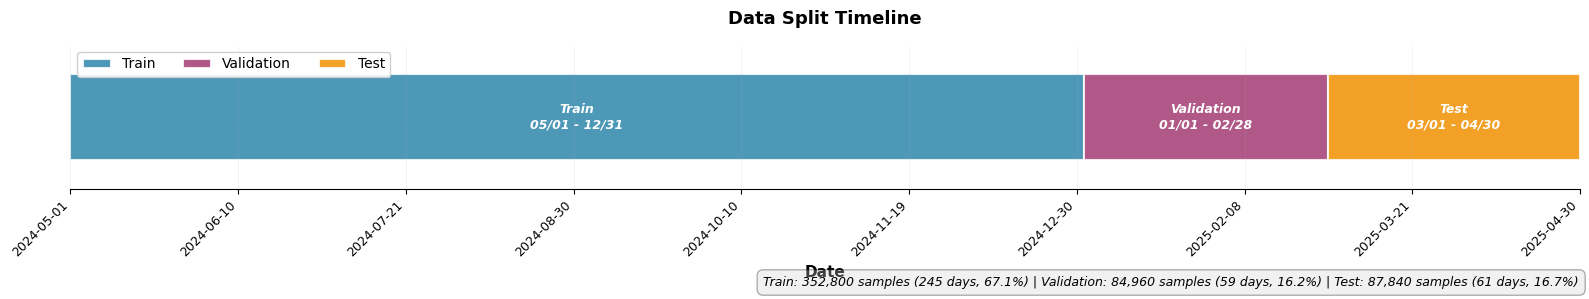

In [27]:
def annualize_factor(sampling: str):
    return ANNUALIZATION.get(sampling, 365*24)

def compute_metrics(equity_curve: pd.Series, sampling: str, turnover_series: pd.Series = None):
    ret = equity_curve.pct_change().dropna()
    ann = annualize_factor(sampling)
    mu = ret.mean() * ann
    sigma = ret.std() * math.sqrt(ann)
    sharpe = mu / (sigma + 1e-12)
    downside = ret[ret < 0].std() * math.sqrt(ann)
    sortino = mu / (downside + 1e-12)
    if len(equity_curve) > 1:
        # Calculate years based on number of samples and sampling frequency
        if isinstance(equity_curve.index, pd.DatetimeIndex):
            dt_years = (equity_curve.index[-1] - equity_curve.index[0]).total_seconds() / (365 * 24 * 3600)
        else:
            # If using RangeIndex, calculate based on sampling frequency
            samples = len(equity_curve)
            samples_per_year = annualize_factor(sampling)
            dt_years = samples / samples_per_year
        dt_years = float(dt_years) if float(dt_years) != 0 else 1e-12
        cagr = (equity_curve.iloc[-1] / equity_curve.iloc[0]) ** (1/dt_years) - 1
    else:
        cagr = 0.0
    cummax = equity_curve.cummax()
    dd = (equity_curve / cummax - 1).min()
    maxdd = float(dd)
    calmar = mu / (abs(maxdd) + 1e-12)
    hit_ratio = (ret > 0).mean()
    turnover = turnover_series.mean() if turnover_series is not None and len(turnover_series)>0 else np.nan
    return {"CAGR": cagr, "Sharpe": sharpe, "Sortino": sortino, "MaxDrawdown": maxdd, "Calmar": calmar, "Volatility": sigma, "Turnover": turnover, "HitRatio": hit_ratio}

def plot_series(series: pd.Series, title: str):
    plt.figure(figsize=(10,4))
    plt.plot(series.index, series.values)
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    plt.show()

def plot_splits(time_index: pd.DatetimeIndex, train_mask: np.ndarray, val_mask: np.ndarray, test_mask: np.ndarray = None):
    """Plot timeline showing training, validation, and test periods on a single timeline."""
    fig, ax = plt.subplots(figsize=(16, 3))
    
    # Create segments for each split type
    splits_data = [
        ('Train', train_mask, '#2E86AB', 0.85),
        ('Validation', val_mask, '#A23B72', 0.85),
    ]
    if test_mask is not None:
        splits_data.append(('Test', test_mask, '#F18F01', 0.85))
    
    # All bars at same height (y=0)
    bar_height = 0.6
    
    # Plot each split as a horizontal bar on the same row
    for label, mask, color, alpha in splits_data:
        # Find continuous segments
        mask_diff = np.diff(np.concatenate(([0], mask.astype(int), [0])))
        starts = np.where(mask_diff == 1)[0]
        ends = np.where(mask_diff == -1)[0]
        
        for start, end in zip(starts, ends):
            # Draw horizontal bar for this segment
            ax.barh(y=0, width=end-start, left=start, height=bar_height, 
                   color=color, alpha=alpha, edgecolor='white', linewidth=1.5, label=label)
            
            # Add label in the middle of the segment
            segment_center = (start + end) / 2
            segment_width = end - start
            
            # Only add text label if segment is wide enough
            if segment_width > len(time_index) * 0.05:  # At least 5% of timeline width
                start_date = time_index[start].strftime('%m/%d')
                end_date = time_index[end-1].strftime('%m/%d')
                ax.text(segment_center, 0, f'{label}\n{start_date} - {end_date}', 
                       va='center', ha='center', fontsize=9, color='white', 
                       fontweight='bold', style='italic')
    
    # Remove duplicate labels in legend
    handles, labels = ax.get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax.legend(by_label.values(), by_label.keys(), loc='upper left', 
             framealpha=0.9, fontsize=10, ncol=len(by_label))
    
    # Set y-axis (hide it since we only have one row)
    ax.set_ylim(-0.5, 0.5)
    ax.set_yticks([])
    
    # Set x-axis ticks to show dates at regular intervals
    num_ticks = 10
    tick_locations = np.linspace(0, len(time_index)-1, num_ticks, dtype=int)
    ax.set_xticks(tick_locations)
    ax.set_xticklabels(time_index[tick_locations].strftime('%Y-%m-%d'), rotation=45, ha='right', fontsize=9)
    
    # Styling
    ax.set_xlabel('Date', fontsize=11, fontweight='bold')
    ax.set_title('Data Split Timeline', fontsize=13, fontweight='bold', pad=15)
    ax.grid(True, axis='x', alpha=0.3, linestyle='--', linewidth=0.5)
    ax.set_xlim(0, len(time_index))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Add summary statistics
    stats_text = []
    for label, mask, _, _ in splits_data:
        n_samples = mask.sum()
        n_days = (time_index[mask][-1] - time_index[mask][0]).days + 1
        pct = (n_samples / len(time_index)) * 100
        stats_text.append(f"{label}: {n_samples:,} samples ({n_days} days, {pct:.1f}%)")
    
    fig.text(0.99, 0.02, ' | '.join(stats_text), 
            ha='right', va='bottom', fontsize=9, style='italic',
            bbox=dict(boxstyle='round,pad=0.5', facecolor='lightgray', alpha=0.3))
    
    plt.tight_layout()
    plt.show()

def backtest_env(env: gym.Env, model=None, include_leverage: bool = False, include_returns: bool = False):
    # Get the unwrapped environment
    unwrapped = env.unwrapped if hasattr(env, 'unwrapped') else env
    
    obs, _ = env.reset()
    pv, turns, levs, actions, rets = [], [], [], [], []  # Initialize lists for portfolio value, turnover, leverage, actions, and returns
    
    for _ in range(len(unwrapped.R)-1):
        if model is None:
            action = np.array([0.0])  # Default to cash position (action=0)
        else:
            action, _ = model.predict(obs, deterministic=True)
        obs, _, done, _, info = env.step(action)
        pv.append(info["portfolio_value"])
        turns.append(info["turnover"])
        levs.append(info["total_leverage"])  # Track leverage from info dict
        actions.append(info.get("action_taken", action[0] if isinstance(action, np.ndarray) else action))  # Track action taken
        rets.append(info.get("portfolio_log_ret", 0.0))  # Track log returns from info dict
        if done:
            break
            
    idx = pd.RangeIndex(start=0, stop=len(pv), step=1)
    ec = pd.Series(pv, index=idx)
    to = pd.Series(turns, index=idx)
    lev = pd.Series(levs, index=idx)  # Create leverage Series
    act = pd.Series(actions, index=idx)  # Create actions Series
    ret = pd.Series(rets, index=idx)  # Create returns Series
    
    if include_returns:
        return ec, to, lev, act, ret
    if include_leverage:
        return ec, to, lev, act
    return ec, to

print("Visualizing data splits timeline...")
plot_splits(TIME_INDEX, train_mask, val_mask, test_mask)

In [28]:
# 🔍 PRE-TRAINING DATA VALIDATION
print("="*70)
print("DATA QUALITY CHECK - Detecting NaN/Inf values")
print("="*70)

# Check tensors for NaN/Inf with progress bar
tensors_to_check = [
    ("X_all", X_all),
    ("R_all", R_all),
    ("VOL_all", VOL_all)
]

nan_check = {}
print("\nScanning tensors for invalid values...")
for tensor_name, tensor in tqdm(tensors_to_check, desc="Validating tensors", unit="tensor"):
    stats = {
        "nan_count": np.isnan(tensor).sum(),
        "inf_count": np.isinf(tensor).sum(),
        "shape": tensor.shape,
        "dtype": tensor.dtype
    }
    
    # Add min/max/mean for R_all
    if tensor_name == "R_all":
        stats["min"] = tensor.min()
        stats["max"] = tensor.max()
        stats["mean"] = tensor.mean()
    
    nan_check[tensor_name] = stats

has_issues = False
print("\nResults:")
for tensor_name, stats in nan_check.items():
    print(f"\n{tensor_name}:")
    print(f"  Shape: {stats['shape']}, Dtype: {stats['dtype']}")
    if 'min' in stats:
        print(f"  Range: [{stats['min']:.6f}, {stats['max']:.6f}], Mean: {stats['mean']:.6f}")
    
    if stats['nan_count'] > 0:
        print(f"  ⚠️  NaN values found: {stats['nan_count']}")
        has_issues = True
    else:
        print("  ✓ No NaN values")
    
    if stats['inf_count'] > 0:
        print(f"  ⚠️  Inf values found: {stats['inf_count']}")
        has_issues = True
    else:
        print("  ✓ No Inf values")

if has_issues:
    print("\n" + "="*70)
    print("❌ DATA QUALITY ISSUES DETECTED!")
    print("="*70)
    print("\nCannot train with NaN/Inf values - this causes gradient explosion.")
    print("\nFix options:")
    print("  1. Re-run feature engineering cells with proper handling")
    print("  2. Check data preprocessing for missing values")
    print("  3. Verify return calculations don't produce invalid values")
    raise ValueError("Training data contains NaN or Inf values")
else:
    print("\n" + "="*70)
    print("✅ DATA QUALITY CHECK PASSED")
    print("="*70)
    print("All tensors are valid - ready for training!\n")

# Clean up validation dictionary
del nan_check
gc.collect()
print_memory_usage()

DATA QUALITY CHECK - Detecting NaN/Inf values

Scanning tensors for invalid values...


Validating tensors: 100%|██████████| 3/3 [01:17<00:00, 25.86s/tensor]


Results:

X_all:
  Shape: (2449894, 1, 32, 60), Dtype: float32
  ✓ No NaN values
  ✓ No Inf values

R_all:
  Shape: (2449894, 2), Dtype: float32
  Range: [-0.123762, 0.090344], Mean: 0.000000
  ✓ No NaN values
  ✓ No Inf values

VOL_all:
  Shape: (2449894, 1), Dtype: float32
  ✓ No NaN values
  ✓ No Inf values

✅ DATA QUALITY CHECK PASSED
All tensors are valid - ready for training!

💾 Current Memory Usage: 6.06 GB (6209.6 MB) - 37.9% of 16.0 GB total


6.0640411376953125

In [29]:
# Check the final concatenated tensors (all_X, all_R, all_VOL were deleted for memory efficiency)
print("Final tensors after concatenation:")
print(f"X_all shape: {X_all.shape}")
print(f"R_all shape: {R_all.shape}")
print(f"VOL_all shape: {VOL_all.shape}")
print(f"\nall_pairs length: {len(all_pairs)}")
print(f"Unique pairs: {len(set(all_pairs))}")
print(f"SAMPLE_TIMESTAMPS length: {len(SAMPLE_TIMESTAMPS)}")
print(f"\ntimestamps variable (from last iteration): type={type(timestamps)}, length={len(timestamps)}")
if len(timestamps) > 0:
    print(f"First 5 timestamps from last iteration: {timestamps[:5]}")
print(f"\nSAMPLE_TIMESTAMPS range: {SAMPLE_TIMESTAMPS.min()} to {SAMPLE_TIMESTAMPS.max()}")

# Clean up intermediate variables (keep all_pairs as it's used later)
del timestamps
# Note: all_pairs is kept as it's used in later cells for pair analysis
gc.collect()
print_memory_usage()

Final tensors after concatenation:
X_all shape: (2449894, 1, 32, 60)
R_all shape: (2449894, 2)
VOL_all shape: (2449894, 1)

all_pairs length: 2449894
Unique pairs: 61
SAMPLE_TIMESTAMPS length: 2449894

timestamps variable (from last iteration): type=<class 'list'>, length=1381
First 5 timestamps from last iteration: [Timestamp('2025-04-13 01:00:00+0000', tz='UTC'), Timestamp('2025-04-13 01:01:00+0000', tz='UTC'), Timestamp('2025-04-13 01:02:00+0000', tz='UTC'), Timestamp('2025-04-13 01:03:00+0000', tz='UTC'), Timestamp('2025-04-13 01:04:00+0000', tz='UTC')]

SAMPLE_TIMESTAMPS range: 2024-05-04 01:00:00+00:00 to 2025-04-30 00:00:00+00:00
💾 Current Memory Usage: 6.06 GB (6208.6 MB) - 37.9% of 16.0 GB total


6.063079833984375

In [30]:
"""
ensure_dir(CONFIG["IO"]["models_dir"])
ensure_dir(CONFIG["EVAL"]["reports_dir"])

# Check if required tensors exist
if 'X_all' not in globals() or 'R_all' not in globals() or 'VOL_all' not in globals() or 'SAMPLE_TIMESTAMPS' not in globals():
    raise NameError(
        "Required tensors (X_all, R_all, VOL_all, SAMPLE_TIMESTAMPS) not found!\n"
        "Please run the tensor construction cell (cell 29) before running this cell.\n"
        "The cell starts with: def build_state_tensor_for_interval..."
    )

RESULTS = []

for split in SPLITS:
    train_env = make_env_from_mask(split["train"], name=f"{split['name']}_train")
    val_env = make_env_from_mask(split["val"], name=f"{split['name']}_val")

    vec_train = DummyVecEnv([lambda env=train_env: env])
    vec_val = DummyVecEnv([lambda env=val_env: env])

    # Get algorithm and action space from config
    algorithm = CONFIG["RL"].get("algorithm", "PPO")
    action_space_type = CONFIG["ENV"].get("action_space_type", "continuous")
    
    print(f"\n{'='*60}")
    print(f"Training {algorithm} model for split: {split['name']}")
    print(f"Action space: {action_space_type}")
    if action_space_type == "discrete":
        print(f"Discrete actions: {CONFIG['ENV']['discrete_actions']}")
    print(f"{'='*60}")
    
    # Configure SDE (State Dependent Exploration) if enabled
    policy_kwargs = None
    if CONFIG["RL"].get("use_sde", False):
        policy_kwargs = {
            "log_std_init": -2.0,  # Initial log std for action noise
        }
        print(f"✅ SDE enabled: sampling action noise every {CONFIG['RL'].get('sde_sample_freq', 4)} steps")
    
    # Create PPO model with correct parameters
    model = PPO(
        policy=CONFIG["RL"]["policy"],
        env=vec_train,
        learning_rate=get_linear_fn(start=CONFIG["RL"]["learning_rate"], end=1e-5, end_fraction=1.0),
        n_steps=CONFIG["RL"]["n_steps"],
        batch_size=CONFIG["RL"]["batch_size"],
        n_epochs=CONFIG["RL"]["n_epochs"],
        gamma=CONFIG["RL"]["gamma"],
        gae_lambda=CONFIG["RL"]["gae_lambda"],
        clip_range=CONFIG["RL"]["clip_range"],
        ent_coef=CONFIG["RL"]["ent_coef"],
        vf_coef=CONFIG["RL"]["vf_coef"],
        max_grad_norm=CONFIG["RL"]["max_grad_norm"],
        use_sde=CONFIG["RL"].get("use_sde", False),
        sde_sample_freq=CONFIG["RL"].get("sde_sample_freq", -1),
        policy_kwargs=policy_kwargs,
        tensorboard_log=CONFIG["IO"]["tb_logdir"],
        device="cpu",
        verbose=0
    )

    # Checkpoint callback to save model periodically during training
    class CheckpointCallback(BaseCallback):
        def __init__(self, save_freq: int, save_path: str, name_prefix: str = "checkpoint", verbose: int = 1):
            super().__init__(verbose)
            self.save_freq = save_freq
            self.save_path = save_path
            self.name_prefix = name_prefix

        def _on_step(self) -> bool:
            if self.n_calls % self.save_freq == 0:
                checkpoint_path = os.path.join(self.save_path, f"{self.name_prefix}_current.zip")
                self.model.save(checkpoint_path)
                if self.verbose > 0:
                    print(f"Checkpoint saved at step {self.num_timesteps} to {checkpoint_path}")
            return True

    # Create callbacks
    eval_callback = EvalCallback(
        vec_val,
        best_model_save_path=CONFIG["IO"]["models_dir"],
        log_path=CONFIG["IO"]["models_dir"],
        eval_freq=CONFIG["EVAL"]["frequency"],
        n_eval_episodes=CONFIG["EVAL"]["n_eval_episodes"],
        deterministic=True,
        render=False,
        verbose=0,
    )
    
    checkpoint_callback = CheckpointCallback(
        save_freq=CONFIG["EVAL"].get("save_freq", 100000),
        save_path=CONFIG["IO"]["models_dir"],
        name_prefix=f"{algorithm.lower()}_checkpoint_{split['name']}",
        verbose=0,
    )
    
    # Action statistics callback to monitor policy health
    action_stats_callback = ActionStatsCallback(
        eval_env=vec_val,
        eval_freq=CONFIG["EVAL"]["frequency"],
        n_eval_episodes=CONFIG["EVAL"]["n_eval_episodes"],
        verbose=0,
    )
    
    callback = CallbackList([eval_callback, action_stats_callback, checkpoint_callback])

    print(f"\nStarting {algorithm} training for {CONFIG['RL']['timesteps']} timesteps...")
    print("Using spreadNorm (z-score) for mean reversion signals")
    print(f"Transaction costs: {CONFIG['ENV']['transaction_costs']['taker_bps']} bps taker fee + {CONFIG['ENV']['transaction_costs']['slippage_bps']} bps slippage")
    if action_space_type == "discrete":
        print("Discrete actions reduce overtrading by forcing significant position jumps")
    
    print("\n⚠️  MEMORY TIP: Close unused notebooks/terminals to free RAM during long training")
    print("   Monitor: Activity Monitor (Mac) or Task Manager (Windows)\n")
    
    # Memory cleanup before training
    gc.collect()
    
    # Train with explicit error handling and checkpointing
    try:
        model.learn(total_timesteps=int(CONFIG["RL"]["timesteps"]), callback=callback, progress_bar=True)
    except KeyboardInterrupt:
        # Use sys.stdout.write to avoid Rich library recursion error in Jupyter
        sys.stdout.write("\n⚠️  Training interrupted by user\n")
        sys.stdout.write("   Saving checkpoint...\n")
        sys.stdout.flush()
        checkpoint_path = os.path.join(CONFIG["IO"]["models_dir"], f"{algorithm.lower()}_interrupted_{split['name']}.zip")
        model.save(checkpoint_path)
        sys.stdout.write(f"   ✓ Checkpoint saved to: {checkpoint_path}\n")
        sys.stdout.flush()
        raise
    except Exception as e:
        # Use sys.stdout.write to avoid Rich library recursion error in Jupyter
        sys.stdout.write(f"\n❌ Training error: {e}\n")
        sys.stdout.write("   Attempting to save emergency checkpoint...\n")
        sys.stdout.flush()
        try:
            emergency_path = os.path.join(CONFIG["IO"]["models_dir"], f"{algorithm.lower()}_emergency_{split['name']}.zip")
            model.save(emergency_path)
            sys.stdout.write(f"   ✓ Emergency checkpoint saved to: {emergency_path}\n")
            sys.stdout.flush()
        except Exception as save_error:
            sys.stdout.write(f"   ✗ Could not save emergency checkpoint: {save_error}\n")
            sys.stdout.flush()
        raise
    finally:
        # Clean up memory after training
        gc.collect()

    final_path = os.path.join(CONFIG["IO"]["models_dir"], "final_model.zip")
    model.save(final_path)
    print(f"Final model saved to {final_path}")

    # Backtest training environment
    print("\nBacktesting on training set...")
    ec_train, to_train, lev_train, act_train = backtest_env(train_env, model=model, include_leverage=True)
    m_model = compute_metrics(ec_train, CONFIG["DATA"]["sampling"], to_train)

    # Backtest equal-weight baseline
    print("Backtesting equal-weight baseline...")
    ec_ew, to_ew, lev_ew, act_ew = backtest_env(train_env, model=None, include_leverage=True)
    m_ew = compute_metrics(ec_ew, CONFIG["DATA"]["sampling"], to_ew)

    # Calculate additional leverage metrics
    model_avg_lev = lev_train.mean()
    model_max_lev = lev_train.max()

    res = {
        "split": split["name"],
        "model_CAGR": m_model["CAGR"],
        "model_Sharpe": m_model["Sharpe"],
        "model_Sortino": m_model["Sortino"],
        "model_Calmar": m_model["Calmar"],
        "model_MaxDrawdown": m_model["MaxDrawdown"],
        "model_Volatility": m_model["Volatility"],
        "model_Turnover": m_model["Turnover"],
        "model_HitRatio": m_model["HitRatio"],
        "model_Avg_Leverage": model_avg_lev,
        "model_Max_Leverage": model_max_lev,
        "equal_weight_CAGR": m_ew["CAGR"],
        "equal_weight_Sharpe": m_ew["Sharpe"],
        "equal_weight_Sortino": m_ew["Sortino"],
        "equal_weight_Calmar": m_ew["Calmar"],
        "equal_weight_MaxDrawdown": m_ew["MaxDrawdown"],
        "equal_weight_Volatility": m_ew["Volatility"],
        "equal_weight_Turnover": m_ew["Turnover"],
        "equal_weight_HitRatio": m_ew["HitRatio"],
    }
    RESULTS.append(res)
    print(f"\nCompleted split: {split['name']}")
    print(f"{algorithm} Model Sharpe: {m_model['Sharpe']:.4f}")
    print(f"Equal-Weight Sharpe: {m_ew['Sharpe']:.4f}")

    # Plot training results
    if CONFIG["EVAL"]["plots"]:
        plt.figure(figsize=(15, 8))

        # Plot equity curves - Model vs Equal Weight Benchmark
        plt.subplot(2, 1, 1)
        plt.plot(ec_train.index, ec_train.values, label=f'{algorithm} Model', color='blue', linewidth=2)
        plt.plot(ec_ew.index, ec_ew.values, label='Equal Weight Benchmark', color='orange', linewidth=2, linestyle='--', alpha=0.7)
        plt.axhline(y=1.0, color='gray', linestyle=':', alpha=0.3, label='Starting Value')
        plt.title(f"Training Set Equity Curve: Model vs Benchmark ({split['name']})")
        plt.xlabel("Steps")
        plt.ylabel("Portfolio Value")
        plt.legend()
        plt.grid(True)

        # Plot actions
        plt.subplot(2, 1, 2)
        plt.plot(act_train.index, act_train.values, label='Action', drawstyle='steps-post', color='purple')
        plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Neutral (Cash)')
        plt.axhline(y=-1, color='red', linestyle=':', alpha=0.3, label='Max Short/Long')
        plt.axhline(y=1, color='green', linestyle=':', alpha=0.3, label='Max Long/Short')
        plt.ylim(-1.1, 1.1)
        plt.title(f"Training Set Trading Actions ({split['name']}) - {action_space_type.capitalize()}")
        plt.xlabel("Steps")
        plt.ylabel("Action Value")
        plt.legend()
        plt.grid(True)

        plt.tight_layout()
        plt.show()

df_results = pd.DataFrame(RESULTS)

"""

'\nensure_dir(CONFIG["IO"]["models_dir"])\nensure_dir(CONFIG["EVAL"]["reports_dir"])\n\n# Check if required tensors exist\nif \'X_all\' not in globals() or \'R_all\' not in globals() or \'VOL_all\' not in globals() or \'SAMPLE_TIMESTAMPS\' not in globals():\n    raise NameError(\n        "Required tensors (X_all, R_all, VOL_all, SAMPLE_TIMESTAMPS) not found!\n"\n        "Please run the tensor construction cell (cell 29) before running this cell.\n"\n        "The cell starts with: def build_state_tensor_for_interval..."\n    )\n\nRESULTS = []\n\nfor split in SPLITS:\n    train_env = make_env_from_mask(split["train"], name=f"{split[\'name\']}_train")\n    val_env = make_env_from_mask(split["val"], name=f"{split[\'name\']}_val")\n\n    vec_train = DummyVecEnv([lambda env=train_env: env])\n    vec_val = DummyVecEnv([lambda env=val_env: env])\n\n    # Get algorithm and action space from config\n    algorithm = CONFIG["RL"].get("algorithm", "PPO")\n    action_space_type = CONFIG["ENV"].get("

In [31]:
"""
# ✅ VALIDATE CONSISTENT FEATURE DIMENSIONS ACROSS SPLITS
print("="*70)
print("VALIDATING FEATURE CONSISTENCY ACROSS TRAIN/VAL/TEST")
print("="*70)

feature_dims = {}
for split in SPLITS:
    print(f"\n{split['name']}:")
    
    for step, mask in [("train", split["train"]), ("val", split["val"]), ("test", split["test"])]:
        X_s, R_s, V_s = slice_by_mask(X_all, R_all, VOL_all, SAMPLE_TIMESTAMPS, mask)
        n_features = X_s.shape[2]
        lookback = X_s.shape[3]
        obs_dim = (n_features * lookback) + 3
        
        print(f"  {step:5s}: {X_s.shape[0]:6,} samples, {n_features:3d} features, obs_dim={obs_dim}")
        
        key = f"{split['name']}_{step}"
        feature_dims[key] = {
            "n_features": n_features,
            "lookback": lookback,
            "obs_dim": obs_dim,
            "samples": X_s.shape[0]
        }

# Check for mismatches
all_obs_dims = [v["obs_dim"] for v in feature_dims.values()]
unique_obs_dims = set(all_obs_dims)

if len(unique_obs_dims) == 1:
    print(f"\n{'='*70}")
    print("✅ ALL SPLITS HAVE CONSISTENT DIMENSIONS!")
    print(f"{'='*70}")
    print(f"Observation dimension: {list(unique_obs_dims)[0]}")
else:
    print(f"\n{'='*70}")
    print("❌ FEATURE MISMATCH DETECTED!")
    print(f"{'='*70}")
    print(f"Found {len(unique_obs_dims)} different observation dimensions: {unique_obs_dims}")
    print("\nThis will cause training/testing errors!")
    print("\nTo fix this:")
    print("1. Check which pairs exist in each time period")
    print("2. Filter to only use pairs that exist in ALL periods")
    print("3. Or retrain model on correct feature set")
    
    raise ValueError(
        f"Feature dimension mismatch across splits! "
        f"Found dimensions: {unique_obs_dims}. "
        f"All splits must have the same number of features."
    )
"""

'\n# ✅ VALIDATE CONSISTENT FEATURE DIMENSIONS ACROSS SPLITS\nprint("="*70)\nprint("VALIDATING FEATURE CONSISTENCY ACROSS TRAIN/VAL/TEST")\nprint("="*70)\n\nfeature_dims = {}\nfor split in SPLITS:\n    print(f"\n{split[\'name\']}:")\n\n    for step, mask in [("train", split["train"]), ("val", split["val"]), ("test", split["test"])]:\n        X_s, R_s, V_s = slice_by_mask(X_all, R_all, VOL_all, SAMPLE_TIMESTAMPS, mask)\n        n_features = X_s.shape[2]\n        lookback = X_s.shape[3]\n        obs_dim = (n_features * lookback) + 3\n\n        print(f"  {step:5s}: {X_s.shape[0]:6,} samples, {n_features:3d} features, obs_dim={obs_dim}")\n\n        key = f"{split[\'name\']}_{step}"\n        feature_dims[key] = {\n            "n_features": n_features,\n            "lookback": lookback,\n            "obs_dim": obs_dim,\n            "samples": X_s.shape[0]\n        }\n\n# Check for mismatches\nall_obs_dims = [v["obs_dim"] for v in feature_dims.values()]\nunique_obs_dims = set(all_obs_dims)\n\n

In [32]:
"""
# Create a DataFrame with all results (already flattened in RESULTS)
df_results = pd.DataFrame(RESULTS)

# Reorder columns to group related metrics together
column_order = ['split']
for model_type in ['model', 'equal_weight']:
    for metric in ['CAGR', 'Sharpe', 'Sortino', 'Calmar', 'MaxDrawdown', 'Volatility', 'Turnover', 'HitRatio']:
        col = f"{model_type}_{metric}"
        if col in df_results.columns:
            column_order.append(col)
    # Add leverage metrics for model only
    if model_type == 'model':
        for metric in ['Avg_Leverage', 'Max_Leverage']:
            col = f"{model_type}_{metric}"
            if col in df_results.columns:
                column_order.append(col)

df_results = df_results[column_order]

# Format only numeric columns, leave 'split' column as-is
format_dict = {col: "{:.4f}" for col in df_results.columns if col != 'split'}
display(df_results.style.format(format_dict))
"""

'\n# Create a DataFrame with all results (already flattened in RESULTS)\ndf_results = pd.DataFrame(RESULTS)\n\n# Reorder columns to group related metrics together\ncolumn_order = [\'split\']\nfor model_type in [\'model\', \'equal_weight\']:\n    for metric in [\'CAGR\', \'Sharpe\', \'Sortino\', \'Calmar\', \'MaxDrawdown\', \'Volatility\', \'Turnover\', \'HitRatio\']:\n        col = f"{model_type}_{metric}"\n        if col in df_results.columns:\n            column_order.append(col)\n    # Add leverage metrics for model only\n    if model_type == \'model\':\n        for metric in [\'Avg_Leverage\', \'Max_Leverage\']:\n            col = f"{model_type}_{metric}"\n            if col in df_results.columns:\n                column_order.append(col)\n\ndf_results = df_results[column_order]\n\n# Format only numeric columns, leave \'split\' column as-is\nformat_dict = {col: "{:.4f}" for col in df_results.columns if col != \'split\'}\ndisplay(df_results.style.format(format_dict))\n'

In [33]:
"""
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
ensure_dir(CONFIG["EVAL"]["reports_dir"])
out_json = os.path.join(CONFIG["EVAL"]["reports_dir"], f"metrics_{ts}.json")
out_csv  = os.path.join(CONFIG["EVAL"]["reports_dir"], f"metrics_{ts}.csv")
df_results.to_csv(out_csv, index=False)
with open(out_json, "w") as f:
    json.dump(RESULTS, f, indent=2)
print("Saved:", out_json, "and", out_csv)
"""

'\nts = datetime.now().strftime("%Y%m%d_%H%M%S")\nensure_dir(CONFIG["EVAL"]["reports_dir"])\nout_json = os.path.join(CONFIG["EVAL"]["reports_dir"], f"metrics_{ts}.json")\nout_csv  = os.path.join(CONFIG["EVAL"]["reports_dir"], f"metrics_{ts}.csv")\ndf_results.to_csv(out_csv, index=False)\nwith open(out_json, "w") as f:\n    json.dump(RESULTS, f, indent=2)\nprint("Saved:", out_json, "and", out_csv)\n'

## Multi-Fee Structure Training

Train multiple models with different fee structures (in basis points). Each model is saved separately and can be used for comparison plots.

In [ ]:
# ========================================
# MULTI-FEE TRAINING FUNCTION
# ========================================

def train_models_with_fees(
    fee_structures: list[float],
    timesteps: int = None,
    base_config: dict = None,
    models_dir: str = None,
    split_index: int = 0,
    verbose: bool = True
) -> dict:
    """
    Train separate models for each fee structure (in basis points).
    
    Parameters
    ----------
    fee_structures : list[float]
        List of fee values in basis points (bps). 
        Examples: [0.0, 1.44, 2.5, 4.5] for no fees, low, medium, high.
    timesteps : int, optional
        Training timesteps per model. Defaults to CONFIG["RL"]["timesteps"].
    base_config : dict, optional
        Base configuration dict. Defaults to CONFIG.
    models_dir : str, optional
        Directory to save models. Defaults to CONFIG["IO"]["models_dir"].
    split_index : int, optional
        Which split to use for training/validation. Default 0.
    verbose : bool, optional
        Print progress messages. Default True.
    
    Returns
    -------
    dict
        Dictionary mapping fee_bps -> model save path
    """
    
    # Use defaults from CONFIG if not provided
    if base_config is None:
        base_config = CONFIG
    if timesteps is None:
        timesteps = int(base_config["RL"]["timesteps"])
    if models_dir is None:
        models_dir = base_config["IO"]["models_dir"]
    
    ensure_dir(models_dir)
    
    # Validate tensors exist
    required_vars = ['X_all', 'R_all', 'VOL_all', 'SAMPLE_TIMESTAMPS', 'SPLITS']
    for var in required_vars:
        if var not in globals():
            raise NameError(f"Required variable '{var}' not found! Run tensor construction cells first.")
    
    trained_models = {}
    split = SPLITS[split_index]
    
    if verbose:
        print("=" * 70)
        print("MULTI-FEE STRUCTURE TRAINING")
        print("=" * 70)
        print(f"Fee structures (bps): {fee_structures}")
        print(f"Timesteps per model: {timesteps:,}")
        print(f"Split: {split['name']}")
        print(f"Models directory: {models_dir}")
        print("=" * 70)
    
    for i, fee_bps in enumerate(fee_structures):
        if verbose:
            print(f"\n{'='*70}")
            print(f"TRAINING MODEL {i+1}/{len(fee_structures)}: {fee_bps} bps fees")
            print(f"{'='*70}")
        
        # Create environment config with this fee structure
        env_config = base_config["ENV"].copy()
        env_config["transaction_costs"] = {
            "taker_bps": fee_bps,
            "maker_bps": base_config["ENV"]["transaction_costs"].get("maker_bps", 0.0),
            "slippage_bps": base_config["ENV"]["transaction_costs"].get("slippage_bps", 0.0)
        }
        
        # Create training and validation environments
        train_env = make_env_from_mask(split["train"], name=f"train_fee{fee_bps}", cfg_env_override=env_config)
        val_env = make_env_from_mask(split["val"], name=f"val_fee{fee_bps}", cfg_env_override=env_config)
        
        vec_train = DummyVecEnv([lambda env=train_env: env])
        vec_val = DummyVecEnv([lambda env=val_env: env])
        
        # Configure policy kwargs for SDE if enabled
        policy_kwargs = None
        if base_config["RL"].get("use_sde", False):
            policy_kwargs = {"log_std_init": -2.0}
        
        # Create PPO model
        model = PPO(
            policy=base_config["RL"]["policy"],
            env=vec_train,
            learning_rate=get_linear_fn(start=base_config["RL"]["learning_rate"], end=1e-5, end_fraction=1.0),
            n_steps=base_config["RL"]["n_steps"],
            batch_size=base_config["RL"]["batch_size"],
            n_epochs=base_config["RL"]["n_epochs"],
            gamma=base_config["RL"]["gamma"],
            gae_lambda=base_config["RL"]["gae_lambda"],
            clip_range=base_config["RL"]["clip_range"],
            ent_coef=base_config["RL"]["ent_coef"],
            vf_coef=base_config["RL"]["vf_coef"],
            max_grad_norm=base_config["RL"]["max_grad_norm"],
            use_sde=base_config["RL"].get("use_sde", False),
            sde_sample_freq=base_config["RL"].get("sde_sample_freq", -1),
            policy_kwargs=policy_kwargs,
            tensorboard_log=base_config["IO"]["tb_logdir"],
            device="cpu",
            verbose=0
        )
        
        # Create eval callback
        # Note: EvalCallback saves best model based on mean reward on validation set
        eval_callback = EvalCallback(
            vec_val,
            best_model_save_path=models_dir,
            log_path=models_dir,
            eval_freq=base_config["EVAL"]["frequency"],
            n_eval_episodes=base_config["EVAL"]["n_eval_episodes"],
            deterministic=True,
            render=False,
            verbose=0  # Show when best model is saved
        )
        
        # Create policy collapse detector
        collapse_callback = PolicyCollapseCallback(
            vec_val,
            check_freq=base_config["EVAL"]["frequency"],  # Check at same freq as eval
            action_std_threshold=base_config["EVAL"]["action_std_threshold"],  # Stop if std of actions is low
            action_extreme_threshold=base_config["EVAL"]["action_extreme_threshold"],  # Stop if stuck at extreme actions
            verbose=1
        )
        
        # Combine callbacks
        # callback = CallbackList([eval_callback, collapse_callback])
        callback = CallbackList([eval_callback])
        
        if verbose:
            print(f"Transaction costs: {fee_bps} bps taker fee")
            print(f"Training for {timesteps:,} timesteps...")
            print(f"✓ Early stopping enabled: will stop if policy collapses")
        
        # Memory cleanup
        gc.collect()
        
        # Train model
        try:
            model.learn(total_timesteps=timesteps, callback=callback, progress_bar=True)
        except KeyboardInterrupt:
            print(f"\n⚠️  Training interrupted for {fee_bps} bps model")
            interrupted_path = os.path.join(models_dir, f"fee_{fee_bps}_bps_interrupted.zip")
            model.save(interrupted_path)
            print(f"   Saved to: {interrupted_path}")
            trained_models[fee_bps] = interrupted_path
            raise
        
        # Generate model filename based on fee structure
        if fee_bps == 0.0:
            model_name = "no_fees.zip"
        elif fee_bps <= 2.0:
            model_name = "low_fees.zip"
        elif fee_bps <= 3.5:
            model_name = "medium_fees.zip"
        else:
            model_name = "high_fees.zip"
        
        # Also save with exact fee value for reference
        exact_name = f"fee_{fee_bps}_bps.zip"
        
        # Save models
        final_path = os.path.join(models_dir, model_name)
        exact_path = os.path.join(models_dir, exact_name)
        
        # model.save(final_path)
        model.save(exact_path)
        
        trained_models[fee_bps] = final_path
        
        if verbose:
            print(f"✅ Model saved: {final_path}")
            print(f"   Also saved: {exact_path}")
        
        # Memory cleanup
        del model
        gc.collect()
    
    if verbose:
        print("\n" + "=" * 70)
        print("TRAINING COMPLETE")
        print("=" * 70)
        print("\nTrained models:")
        for fee, path in trained_models.items():
            print(f"  • {fee:6.2f} bps → {path}")
        print("=" * 70)
    
    return trained_models


# ========================================
# EXAMPLE USAGE
# ========================================
# Uncomment and modify the fee structures you want to train:

# FEE_STRUCTURES = [0.0, 1.44, 4.5]  # No fees, Low (Hyperliquid tier), High
FEE_STRUCTURES = CONFIG["ENV"]["transaction_costs"].get("fee_structures", [0.0, 1.44, 4.5])
TIMESTEPS = CONFIG["RL"]["timesteps"]
trained_paths = train_models_with_fees(
    fee_structures=FEE_STRUCTURES,
    timesteps=TIMESTEPS,  # Adjust as needed
)

print("✅ Multi-fee training function defined")
print("\nUsage example:")
print("  trained_paths = train_models_with_fees([0.0, 1.44, 4.5])")

MULTI-FEE STRUCTURE TRAINING
Fee structures (bps): [0.0, 1.44, 4.5]
Timesteps per model: 2,000,000.0
Split: 2024-05-01 to 2025-04-30
Models directory: ./models

TRAINING MODEL 1/3: 0.0 bps fees
Slicing: 1644766 samples out of 2449894 fall in range 2024-05-01 00:00:00+00:00 to 2024-12-31 23:59:00+00:00
  X: shape=(1644766, 1, 32, 60), range=[-28.7972, 8539.4990]
  R: shape=(1644766, 2), range=[-0.0943, 0.0628]
  V: shape=(1644766, 1), range=[0.0000, 28.7972]
Slicing: 399109 samples out of 2449894 fall in range 2025-01-01 00:00:00+00:00 to 2025-02-28 23:59:00+00:00
  X: shape=(399109, 1, 32, 60), range=[-33.6430, 29234.4453]
  R: shape=(399109, 2), range=[-0.1238, 0.0903]
  V: shape=(399109, 1), range=[0.0000, 28.9668]


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/stable_baselines3/common/utils.py:195: UserWarning: get_linear_fn() is deprecated, please use LinearSchedule() instead
  warnings.warn("get_linear_fn() is deprecated, please use LinearSchedule() instead")


Output()

Transaction costs: 0.0 bps taker fee
Training for 2,000,000.0 timesteps...
✓ Early stopping enabled: will stop if policy collapses


Eval num_timesteps=14400, episode_reward=-0.14 +/- 0.01

Episode length: 367430.33 +/- 32205.41

New best mean reward!

Eval num_timesteps=28800, episode_reward=-0.18 +/- 0.00

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=43200, episode_reward=0.05 +/- 0.02

Episode length: 367430.33 +/- 32205.41

New best mean reward!

Eval num_timesteps=57600, episode_reward=-0.04 +/- 0.06

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=72000, episode_reward=-0.01 +/- 0.00

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=86400, episode_reward=-0.06 +/- 0.01

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=100800, episode_reward=-0.04 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=115200, episode_reward=0.02 +/- 0.04

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=129600, episode_reward=0.14 +/- 0.02

Episode length: 367430.33 +/- 32205.41

New best mean reward!

Eval num_timesteps=144000, episode_reward=-0.28 +/- 0.11

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=158400, episode_reward=-0.53 +/- 0.10

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=172800, episode_reward=-0.64 +/- 0.11

Eval num_timesteps=187200, episode_reward=-0.34 +/- 0.07

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=201600, episode_reward=-0.52 +/- 0.11

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=216000, episode_reward=-0.50 +/- 0.10

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=230400, episode_reward=-0.43 +/- 0.09

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=244800, episode_reward=-0.28 +/- 0.04

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=259200, episode_reward=-0.30 +/- 0.07

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=273600, episode_reward=-0.25 +/- 0.14

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=288000, episode_reward=-0.38 +/- 0.09

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=302400, episode_reward=-0.40 +/- 0.07

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=316800, episode_reward=-0.33 +/- 0.09

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=331200, episode_reward=-0.46 +/- 0.13

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=345600, episode_reward=-0.64 +/- 0.11

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=360000, episode_reward=-0.75 +/- 0.10

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=374400, episode_reward=-0.62 +/- 0.10

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=388800, episode_reward=-0.29 +/- 0.06

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=403200, episode_reward=-0.41 +/- 0.08

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=417600, episode_reward=-0.55 +/- 0.08

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=432000, episode_reward=-0.41 +/- 0.11

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=446400, episode_reward=-0.37 +/- 0.09

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=460800, episode_reward=-0.22 +/- 0.10

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=475200, episode_reward=-0.45 +/- 0.09

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=489600, episode_reward=-0.51 +/- 0.11

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=504000, episode_reward=-0.55 +/- 0.08

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=518400, episode_reward=-0.63 +/- 0.09

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=532800, episode_reward=-0.68 +/- 0.10

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=547200, episode_reward=-0.41 +/- 0.06

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=561600, episode_reward=-0.55 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=576000, episode_reward=-0.38 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=590400, episode_reward=-0.27 +/- 0.06

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=604800, episode_reward=-0.01 +/- 0.03

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=619200, episode_reward=-0.27 +/- 0.07

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=633600, episode_reward=-0.52 +/- 0.06

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=648000, episode_reward=-0.73 +/- 0.13

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=662400, episode_reward=-0.57 +/- 0.08

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=676800, episode_reward=-0.61 +/- 0.11

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=691200, episode_reward=-0.40 +/- 0.08

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=705600, episode_reward=-0.55 +/- 0.11

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=720000, episode_reward=-0.56 +/- 0.11

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=734400, episode_reward=-0.60 +/- 0.10

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=748800, episode_reward=-0.62 +/- 0.11

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=763200, episode_reward=-0.53 +/- 0.11

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=777600, episode_reward=-0.30 +/- 0.06

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=792000, episode_reward=-0.19 +/- 0.02

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=806400, episode_reward=-0.32 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=820800, episode_reward=-0.50 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=835200, episode_reward=-0.55 +/- 0.06

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=849600, episode_reward=-0.67 +/- 0.06

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=864000, episode_reward=-0.37 +/- 0.10

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=878400, episode_reward=-0.49 +/- 0.09

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=892800, episode_reward=-0.24 +/- 0.04

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=907200, episode_reward=-0.43 +/- 0.09

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=921600, episode_reward=-0.37 +/- 0.08

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=936000, episode_reward=-0.51 +/- 0.08

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=950400, episode_reward=-0.45 +/- 0.10

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=964800, episode_reward=-0.56 +/- 0.12

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=979200, episode_reward=-0.76 +/- 0.11

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=993600, episode_reward=-0.62 +/- 0.10

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1008000, episode_reward=-0.32 +/- 0.04

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1022400, episode_reward=-0.18 +/- 0.07

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1036800, episode_reward=-0.36 +/- 0.02

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1051200, episode_reward=-0.03 +/- 0.01

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1080000, episode_reward=-0.04 +/- 0.00

Eval num_timesteps=1094400, episode_reward=-0.05 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1108800, episode_reward=-0.20 +/- 0.03

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1123200, episode_reward=-0.09 +/- 0.01

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1137600, episode_reward=0.02 +/- 0.04

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1152000, episode_reward=-0.32 +/- 0.01

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1166400, episode_reward=-0.26 +/- 0.02

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1180800, episode_reward=-0.51 +/- 0.06

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1195200, episode_reward=-0.31 +/- 0.00

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1209600, episode_reward=-0.07 +/- 0.01

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1224000, episode_reward=-0.03 +/- 0.04

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1238400, episode_reward=-0.18 +/- 0.03

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1252800, episode_reward=-0.63 +/- 0.09

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1267200, episode_reward=-0.59 +/- 0.08

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1281600, episode_reward=-0.14 +/- 0.02

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1296000, episode_reward=0.00 +/- 0.01

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1310400, episode_reward=-0.07 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1324800, episode_reward=-0.23 +/- 0.01

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1339200, episode_reward=-0.40 +/- 0.02

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1353600, episode_reward=-0.38 +/- 0.10

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1368000, episode_reward=-0.31 +/- 0.02

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1382400, episode_reward=-0.35 +/- 0.03

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1396800, episode_reward=0.03 +/- 0.04

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1411200, episode_reward=-0.51 +/- 0.10

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1425600, episode_reward=-0.19 +/- 0.02

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1440000, episode_reward=-0.73 +/- 0.13

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1454400, episode_reward=-0.29 +/- 0.07

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1468800, episode_reward=-0.70 +/- 0.08

Eval num_timesteps=1483200, episode_reward=-0.35 +/- 0.03

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1497600, episode_reward=-0.16 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1512000, episode_reward=-0.43 +/- 0.03

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1526400, episode_reward=-0.31 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1540800, episode_reward=-0.61 +/- 0.09

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1555200, episode_reward=-0.73 +/- 0.09

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1569600, episode_reward=-0.52 +/- 0.12

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1584000, episode_reward=-0.51 +/- 0.06

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1598400, episode_reward=-0.50 +/- 0.01

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1612800, episode_reward=-0.49 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1627200, episode_reward=-0.41 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1641600, episode_reward=-0.66 +/- 0.04

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1656000, episode_reward=-0.12 +/- 0.04

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1670400, episode_reward=-0.36 +/- 0.01

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1684800, episode_reward=-0.14 +/- 0.06

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1699200, episode_reward=-0.09 +/- 0.06

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1713600, episode_reward=-0.35 +/- 0.07

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1728000, episode_reward=-0.34 +/- 0.04

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1742400, episode_reward=-0.45 +/- 0.10

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1756800, episode_reward=-0.60 +/- 0.17

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1771200, episode_reward=-0.60 +/- 0.15

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1785600, episode_reward=-0.54 +/- 0.10

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1800000, episode_reward=-0.54 +/- 0.14

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1814400, episode_reward=-0.46 +/- 0.18

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1828800, episode_reward=-0.49 +/- 0.10

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1843200, episode_reward=-0.64 +/- 0.18

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1857600, episode_reward=-0.58 +/- 0.15

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1872000, episode_reward=-0.52 +/- 0.10

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1886400, episode_reward=-0.34 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1900800, episode_reward=-0.41 +/- 0.04

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1915200, episode_reward=-0.39 +/- 0.01

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1929600, episode_reward=-0.65 +/- 0.07

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1944000, episode_reward=-0.69 +/- 0.07

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1958400, episode_reward=-0.73 +/- 0.08

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1972800, episode_reward=-0.70 +/- 0.07

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1987200, episode_reward=-0.75 +/- 0.05

Episode length: 367430.33 +/- 32205.41

✅ Model saved: ./models/no_fees.zip
   Also saved: ./models/fee_0.0_bps.zip

TRAINING MODEL 2/3: 1.44 bps fees
Slicing: 1644766 samples out of 2449894 fall in range 2024-05-01 00:00:00+00:00 to 2024-12-31 23:59:00+00:00
  X: shape=(1644766, 1, 32, 60), range=[-28.7972, 8539.4990]
  R: shape=(1644766, 2), range=[-0.0943, 0.0628]
  V: shape=(1644766, 1), range=[0.0000, 28.7972]
Slicing: 399109 samples out of 2449894 fall in range 2025-01-01 00:00:00+00:00 to 2025-02-28 23:59:00+00:00
  X: shape=(399109, 1, 32, 60), range=[-33.6430, 29234.4453]
  R: shape=(399109, 2), range=[-0.1238, 0.0903]
  V: shape=(399109, 1), range=[0.0000, 28.9668]
Transaction costs: 1.44 bps taker fee
Training for 2,000,000.0 timesteps...
✓ Early stopping enabled: will stop if policy collapses


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/stable_baselines3/common/utils.py:195: UserWarning: get_linear_fn() is deprecated, please use LinearSchedule() instead
  warnings.warn("get_linear_fn() is deprecated, please use LinearSchedule() instead")


Output()

Eval num_timesteps=14400, episode_reward=-0.45 +/- 0.10

Episode length: 367430.33 +/- 32205.41

New best mean reward!

Eval num_timesteps=28800, episode_reward=-0.49 +/- 0.07

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=43200, episode_reward=-0.53 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=57600, episode_reward=-0.56 +/- 0.04

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=72000, episode_reward=-0.67 +/- 0.03

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=86400, episode_reward=-0.72 +/- 0.06

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=100800, episode_reward=-0.79 +/- 0.10

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=115200, episode_reward=-0.90 +/- 0.09

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=129600, episode_reward=-0.91 +/- 0.07

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=144000, episode_reward=-0.72 +/- 0.03

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=158400, episode_reward=-0.56 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=172800, episode_reward=-0.73 +/- 0.04

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=187200, episode_reward=-0.73 +/- 0.01

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=201600, episode_reward=-0.69 +/- 0.03

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=216000, episode_reward=-0.64 +/- 0.04

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=230400, episode_reward=-0.82 +/- 0.02

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=244800, episode_reward=-0.55 +/- 0.08

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=259200, episode_reward=-0.54 +/- 0.06

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=273600, episode_reward=-0.40 +/- 0.07

Episode length: 367430.33 +/- 32205.41

New best mean reward!

Eval num_timesteps=288000, episode_reward=-0.43 +/- 0.08

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=302400, episode_reward=-0.19 +/- 0.07

Episode length: 367430.33 +/- 32205.41

New best mean reward!

Eval num_timesteps=316800, episode_reward=-0.12 +/- 0.07

Episode length: 367430.33 +/- 32205.41

New best mean reward!

Eval num_timesteps=331200, episode_reward=-0.13 +/- 0.07

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=345600, episode_reward=-0.23 +/- 0.07

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=360000, episode_reward=-0.26 +/- 0.09

Eval num_timesteps=374400, episode_reward=-0.62 +/- 0.04

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=388800, episode_reward=-1.00 +/- 0.00

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=403200, episode_reward=-1.44 +/- 0.09

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=417600, episode_reward=-0.89 +/- 0.04

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=432000, episode_reward=-0.95 +/- 0.01

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=446400, episode_reward=-0.95 +/- 0.03

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=460800, episode_reward=-0.92 +/- 0.03

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=475200, episode_reward=-0.99 +/- 0.00

Eval num_timesteps=489600, episode_reward=-1.01 +/- 0.01

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=504000, episode_reward=-0.99 +/- 0.02

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=518400, episode_reward=-0.99 +/- 0.04

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=532800, episode_reward=-0.88 +/- 0.03

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=547200, episode_reward=-0.86 +/- 0.03

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=561600, episode_reward=-0.49 +/- 0.08

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=576000, episode_reward=-0.39 +/- 0.04

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=590400, episode_reward=-0.53 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=604800, episode_reward=-0.40 +/- 0.07

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=619200, episode_reward=-0.07 +/- 0.06

Episode length: 367430.33 +/- 32205.41

New best mean reward!

Eval num_timesteps=633600, episode_reward=-0.66 +/- 0.06

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=648000, episode_reward=-0.92 +/- 0.02

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=662400, episode_reward=-0.71 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=676800, episode_reward=-0.81 +/- 0.06

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=691200, episode_reward=-0.85 +/- 0.00

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=705600, episode_reward=-0.63 +/- 0.02

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=720000, episode_reward=-0.71 +/- 0.01

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=734400, episode_reward=-0.84 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=748800, episode_reward=-0.70 +/- 0.00

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=763200, episode_reward=-0.57 +/- 0.02

Eval num_timesteps=777600, episode_reward=-1.02 +/- 0.08

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=792000, episode_reward=-1.06 +/- 0.09

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=806400, episode_reward=-0.71 +/- 0.09

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=820800, episode_reward=-0.76 +/- 0.08

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=835200, episode_reward=-0.84 +/- 0.09

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=849600, episode_reward=-0.49 +/- 0.03

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=864000, episode_reward=-0.63 +/- 0.08

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=878400, episode_reward=-0.82 +/- 0.07

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=892800, episode_reward=-0.69 +/- 0.09

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=907200, episode_reward=-0.57 +/- 0.01

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=921600, episode_reward=-0.71 +/- 0.03

Eval num_timesteps=936000, episode_reward=-0.69 +/- 0.04

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=950400, episode_reward=-0.76 +/- 0.06

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=964800, episode_reward=-0.57 +/- 0.06

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=979200, episode_reward=-0.98 +/- 0.04

Eval num_timesteps=993600, episode_reward=-0.70 +/- 0.02

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1008000, episode_reward=-0.96 +/- 0.03

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1022400, episode_reward=-0.71 +/- 0.02

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1036800, episode_reward=-0.79 +/- 0.05

Eval num_timesteps=1051200, episode_reward=-0.55 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1065600, episode_reward=-0.98 +/- 0.06

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1080000, episode_reward=-0.99 +/- 0.09

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1094400, episode_reward=-0.89 +/- 0.08

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1108800, episode_reward=-1.01 +/- 0.07

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1123200, episode_reward=-1.02 +/- 0.06

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1137600, episode_reward=-0.88 +/- 0.10

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1152000, episode_reward=-0.96 +/- 0.02

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1166400, episode_reward=-0.75 +/- 0.02

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1180800, episode_reward=-0.65 +/- 0.01

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1195200, episode_reward=-0.45 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1209600, episode_reward=-0.65 +/- 0.02

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1224000, episode_reward=-0.59 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1238400, episode_reward=-0.59 +/- 0.06

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1252800, episode_reward=-0.78 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1267200, episode_reward=-0.98 +/- 0.13

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1281600, episode_reward=-0.87 +/- 0.07

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1296000, episode_reward=-0.86 +/- 0.11

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1310400, episode_reward=-0.80 +/- 0.11

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1324800, episode_reward=-0.90 +/- 0.13

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1339200, episode_reward=-0.59 +/- 0.06

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1353600, episode_reward=-0.77 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1368000, episode_reward=-0.65 +/- 0.07

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1382400, episode_reward=-0.78 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1396800, episode_reward=-0.38 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1411200, episode_reward=-0.59 +/- 0.12

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1425600, episode_reward=-0.47 +/- 0.06

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1440000, episode_reward=-0.68 +/- 0.10

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1454400, episode_reward=-0.92 +/- 0.08

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1468800, episode_reward=-0.83 +/- 0.04

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1483200, episode_reward=-0.83 +/- 0.10

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1497600, episode_reward=-0.70 +/- 0.08

Eval num_timesteps=1512000, episode_reward=-0.90 +/- 0.07

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1526400, episode_reward=-0.72 +/- 0.10

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1540800, episode_reward=-0.77 +/- 0.02

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1555200, episode_reward=-1.03 +/- 0.09

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1569600, episode_reward=-0.53 +/- 0.11

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1584000, episode_reward=-0.94 +/- 0.08

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1598400, episode_reward=-0.87 +/- 0.09

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1612800, episode_reward=-0.95 +/- 0.08

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1627200, episode_reward=-0.94 +/- 0.14

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1641600, episode_reward=-0.75 +/- 0.01

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1656000, episode_reward=-0.81 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1670400, episode_reward=-0.84 +/- 0.08

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1684800, episode_reward=-0.86 +/- 0.12

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1699200, episode_reward=-0.79 +/- 0.15

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1713600, episode_reward=-1.22 +/- 0.09

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1728000, episode_reward=-0.76 +/- 0.11

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1742400, episode_reward=-0.72 +/- 0.16

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1756800, episode_reward=-0.66 +/- 0.08

Eval num_timesteps=1771200, episode_reward=-0.83 +/- 0.10

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1785600, episode_reward=-0.98 +/- 0.03

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1800000, episode_reward=-0.78 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1814400, episode_reward=-0.74 +/- 0.07

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1828800, episode_reward=-0.72 +/- 0.03

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1843200, episode_reward=-0.54 +/- 0.01

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1857600, episode_reward=-0.43 +/- 0.05

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1872000, episode_reward=-0.49 +/- 0.06

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1886400, episode_reward=-0.66 +/- 0.00

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1900800, episode_reward=-0.56 +/- 0.04

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1915200, episode_reward=-0.44 +/- 0.02

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1929600, episode_reward=-0.82 +/- 0.01

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1944000, episode_reward=-0.83 +/- 0.01

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1958400, episode_reward=-0.57 +/- 0.01

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1972800, episode_reward=-0.70 +/- 0.03

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1987200, episode_reward=-0.64 +/- 0.00

Episode length: 367430.33 +/- 32205.41

✅ Model saved: ./models/low_fees.zip
   Also saved: ./models/fee_1.44_bps.zip

TRAINING MODEL 3/3: 4.5 bps fees
Slicing: 1644766 samples out of 2449894 fall in range 2024-05-01 00:00:00+00:00 to 2024-12-31 23:59:00+00:00
  X: shape=(1644766, 1, 32, 60), range=[-28.7972, 8539.4990]
  R: shape=(1644766, 2), range=[-0.0943, 0.0628]
  V: shape=(1644766, 1), range=[0.0000, 28.7972]
Slicing: 399109 samples out of 2449894 fall in range 2025-01-01 00:00:00+00:00 to 2025-02-28 23:59:00+00:00
  X: shape=(399109, 1, 32, 60), range=[-33.6430, 29234.4453]
  R: shape=(399109, 2), range=[-0.1238, 0.0903]
  V: shape=(399109, 1), range=[0.0000, 28.9668]
Transaction costs: 4.5 bps taker fee
Training for 2,000,000.0 timesteps...
✓ Early stopping enabled: will stop if policy collapses


Output()

Eval num_timesteps=14400, episode_reward=-3.61 +/- 0.41

Episode length: 367430.33 +/- 32205.41

New best mean reward!

Eval num_timesteps=28800, episode_reward=-2.56 +/- 0.25

Episode length: 367430.33 +/- 32205.41

New best mean reward!

Eval num_timesteps=43200, episode_reward=-2.48 +/- 0.28

Episode length: 367430.33 +/- 32205.41

New best mean reward!

Eval num_timesteps=57600, episode_reward=-2.76 +/- 0.27

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=72000, episode_reward=-2.57 +/- 0.26

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=86400, episode_reward=-2.36 +/- 0.25

Episode length: 367430.33 +/- 32205.41

New best mean reward!

Eval num_timesteps=100800, episode_reward=-1.88 +/- 0.19

Episode length: 367430.33 +/- 32205.41

New best mean reward!

Eval num_timesteps=115200, episode_reward=-1.85 +/- 0.20

Episode length: 367430.33 +/- 32205.41

New best mean reward!

Eval num_timesteps=129600, episode_reward=-1.72 +/- 0.18

New best mean reward!

Eval num_timesteps=144000, episode_reward=-1.75 +/- 0.20

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=158400, episode_reward=-1.55 +/- 0.19

Episode length: 367430.33 +/- 32205.41

New best mean reward!

Eval num_timesteps=172800, episode_reward=-1.43 +/- 0.17

Episode length: 367430.33 +/- 32205.41

New best mean reward!

Eval num_timesteps=187200, episode_reward=-1.54 +/- 0.18

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=201600, episode_reward=-1.53 +/- 0.18

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=216000, episode_reward=-1.33 +/- 0.18

Episode length: 367430.33 +/- 32205.41

New best mean reward!

Eval num_timesteps=230400, episode_reward=-1.59 +/- 0.16

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=244800, episode_reward=-1.59 +/- 0.18

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=259200, episode_reward=-1.79 +/- 0.17

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=273600, episode_reward=-1.72 +/- 0.17

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=288000, episode_reward=-1.98 +/- 0.19

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=302400, episode_reward=-2.15 +/- 0.19

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=316800, episode_reward=-2.16 +/- 0.19

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=331200, episode_reward=-2.42 +/- 0.19

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=345600, episode_reward=-2.17 +/- 0.17

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=360000, episode_reward=-2.13 +/- 0.20

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=374400, episode_reward=-1.55 +/- 0.15

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=388800, episode_reward=-1.65 +/- 0.16

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=403200, episode_reward=-1.87 +/- 0.17

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=417600, episode_reward=-2.00 +/- 0.21

Eval num_timesteps=432000, episode_reward=-1.74 +/- 0.17

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=446400, episode_reward=-1.84 +/- 0.19

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=460800, episode_reward=-1.55 +/- 0.19

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=475200, episode_reward=-1.70 +/- 0.19

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=489600, episode_reward=-1.80 +/- 0.20

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=504000, episode_reward=-1.56 +/- 0.18

Eval num_timesteps=518400, episode_reward=-1.64 +/- 0.18

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=532800, episode_reward=-1.47 +/- 0.15

Eval num_timesteps=547200, episode_reward=-2.05 +/- 0.19

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=561600, episode_reward=-1.78 +/- 0.19

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=576000, episode_reward=-1.69 +/- 0.16

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=590400, episode_reward=-2.52 +/- 0.23

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=604800, episode_reward=-2.21 +/- 0.18

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=619200, episode_reward=-2.42 +/- 0.14

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=633600, episode_reward=-2.37 +/- 0.19

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=648000, episode_reward=-1.88 +/- 0.18

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=662400, episode_reward=-2.03 +/- 0.17

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=676800, episode_reward=-2.41 +/- 0.23

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=691200, episode_reward=-2.37 +/- 0.22

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=705600, episode_reward=-2.44 +/- 0.24

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=720000, episode_reward=-1.98 +/- 0.18

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=734400, episode_reward=-2.15 +/- 0.19

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=748800, episode_reward=-2.38 +/- 0.21

Eval num_timesteps=763200, episode_reward=-2.38 +/- 0.23

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=777600, episode_reward=-2.76 +/- 0.24

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=792000, episode_reward=-2.42 +/- 0.22

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=806400, episode_reward=-2.09 +/- 0.21

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=820800, episode_reward=-2.44 +/- 0.26

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=835200, episode_reward=-2.67 +/- 0.25

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=849600, episode_reward=-2.19 +/- 0.21

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=864000, episode_reward=-1.56 +/- 0.15

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=878400, episode_reward=-2.63 +/- 0.22

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=892800, episode_reward=-2.43 +/- 0.20

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=907200, episode_reward=-2.65 +/- 0.20

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=921600, episode_reward=-2.80 +/- 0.27

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=936000, episode_reward=-2.72 +/- 0.24

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=950400, episode_reward=-2.58 +/- 0.21

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=964800, episode_reward=-2.52 +/- 0.29

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=979200, episode_reward=-2.26 +/- 0.26

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=993600, episode_reward=-2.77 +/- 0.20

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1008000, episode_reward=-0.87 +/- 0.05

New best mean reward!

Eval num_timesteps=1022400, episode_reward=-1.03 +/- 0.09

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1036800, episode_reward=-1.07 +/- 0.08

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1051200, episode_reward=-1.40 +/- 0.16

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1065600, episode_reward=-1.82 +/- 0.21

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1080000, episode_reward=-2.06 +/- 0.19

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1094400, episode_reward=-1.63 +/- 0.19

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1108800, episode_reward=-1.89 +/- 0.20

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1123200, episode_reward=-1.99 +/- 0.21

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1137600, episode_reward=-2.22 +/- 0.18

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1152000, episode_reward=-2.36 +/- 0.22

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1166400, episode_reward=-2.07 +/- 0.16

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1180800, episode_reward=-2.21 +/- 0.21

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1195200, episode_reward=-0.98 +/- 0.08

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1209600, episode_reward=-2.02 +/- 0.15

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1224000, episode_reward=-2.02 +/- 0.13

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1238400, episode_reward=-2.34 +/- 0.22

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1252800, episode_reward=-1.98 +/- 0.29

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1267200, episode_reward=-1.47 +/- 0.27

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1281600, episode_reward=-2.18 +/- 0.19

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1296000, episode_reward=-1.59 +/- 0.26

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1310400, episode_reward=-2.02 +/- 0.20

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1324800, episode_reward=-2.46 +/- 0.26

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1339200, episode_reward=-1.81 +/- 0.23

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1353600, episode_reward=-2.14 +/- 0.28

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1368000, episode_reward=-1.46 +/- 0.23

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1382400, episode_reward=-1.37 +/- 0.21

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1396800, episode_reward=-1.59 +/- 0.17

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1411200, episode_reward=-1.89 +/- 0.20

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1425600, episode_reward=-2.18 +/- 0.10

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1440000, episode_reward=-1.76 +/- 0.18

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1454400, episode_reward=-1.81 +/- 0.19

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1468800, episode_reward=-2.13 +/- 0.13

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1483200, episode_reward=-1.86 +/- 0.18

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1497600, episode_reward=-1.21 +/- 0.04

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1512000, episode_reward=-1.06 +/- 0.02

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1526400, episode_reward=-0.61 +/- 0.06

Episode length: 367430.33 +/- 32205.41

New best mean reward!

Eval num_timesteps=1540800, episode_reward=-2.15 +/- 0.08

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1555200, episode_reward=-1.35 +/- 0.15

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1569600, episode_reward=-2.30 +/- 0.14

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1584000, episode_reward=-1.97 +/- 0.23

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1598400, episode_reward=-1.80 +/- 0.23

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1612800, episode_reward=-2.27 +/- 0.20

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1627200, episode_reward=-2.36 +/- 0.25

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1641600, episode_reward=-0.92 +/- 0.16

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1656000, episode_reward=-1.69 +/- 0.04

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1670400, episode_reward=-2.12 +/- 0.20

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1684800, episode_reward=-1.72 +/- 0.03

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1699200, episode_reward=-1.32 +/- 0.19

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1713600, episode_reward=-2.16 +/- 0.02

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1728000, episode_reward=-1.27 +/- 0.19

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1742400, episode_reward=-2.18 +/- 0.27

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1756800, episode_reward=-2.06 +/- 0.26

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1771200, episode_reward=-2.20 +/- 0.11

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1785600, episode_reward=-2.10 +/- 0.21

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1800000, episode_reward=-1.78 +/- 0.13

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1814400, episode_reward=-2.14 +/- 0.13

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1828800, episode_reward=-2.24 +/- 0.17

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1843200, episode_reward=-2.28 +/- 0.21

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1857600, episode_reward=-2.18 +/- 0.20

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1872000, episode_reward=-1.96 +/- 0.14

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1886400, episode_reward=-2.17 +/- 0.15

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1900800, episode_reward=-2.14 +/- 0.12

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1915200, episode_reward=-2.01 +/- 0.09

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1929600, episode_reward=-2.11 +/- 0.19

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1944000, episode_reward=-2.05 +/- 0.14

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1958400, episode_reward=-2.09 +/- 0.14

Episode length: 367430.33 +/- 32205.41

Eval num_timesteps=1972800, episode_reward=-2.08 +/- 0.09

Eval num_timesteps=1987200, episode_reward=-1.70 +/- 0.02

Episode length: 367430.33 +/- 32205.41

✅ Model saved: ./models/high_fees.zip
   Also saved: ./models/fee_4.5_bps.zip

TRAINING COMPLETE

Trained models:
  •   0.00 bps → ./models/no_fees.zip
  •   1.44 bps → ./models/low_fees.zip
  •   4.50 bps → ./models/high_fees.zip
✅ Multi-fee training function defined

Usage example:
  trained_paths = train_models_with_fees([0.0, 1.44, 4.5])


# Multi-Model Comparison: Different Fee Structures

Compare three models trained with different fee structures and evaluate them with their respective fees.

In [56]:
# ========================================
# MULTI-MODEL COMPARISON SETUP
# ========================================

# Define model configurations
MODEL_CONFIGS = [
    {
        "name": "No Fees",
        "model_path": os.path.join(CONFIG["IO"]["models_dir"], "no_fees.zip"),
        "fee_bps": 0.0,
        "color": "#2ECC71", 
        "linestyle": "-"
    },
    {
        "name": "Low Fees", 
        "model_path": os.path.join(CONFIG["IO"]["models_dir"], "low_fees.zip"),
        "fee_bps": 1.44,
        "color": "#F39C12",
        "linestyle": "-"
    },
    {
        "name": "High Fees",
        "model_path": os.path.join(CONFIG["IO"]["models_dir"], "high_fees.zip"),
        "fee_bps": 4.5,
        "color": "#E74C3C",
        "linestyle": "-"
    }
]
"""
FEE_STRUCTURES = CONFIG["ENV"]["transaction_costs"].get("fee_structures", [0.0, 1.44, 4.5])

for fee in FEE_STRUCTURES:
    model_name = f"fee_{fee}_bps.zip"
    model_path = os.path.join(CONFIG["IO"]["models_dir"], model_name)
    MODEL_CONFIGS.append({
        "name": f"{fee} bps",
        "model_path": model_path,
        "fee_bps": fee,
        "color": "#3498DB",
        "linestyle": "-"
    })

print("Configurations Loaded Successfully")
"""

'\nFEE_STRUCTURES = CONFIG["ENV"]["transaction_costs"].get("fee_structures", [0.0, 1.44, 4.5])\n\nfor fee in FEE_STRUCTURES:\n    model_name = f"fee_{fee}_bps.zip"\n    model_path = os.path.join(CONFIG["IO"]["models_dir"], model_name)\n    MODEL_CONFIGS.append({\n        "name": f"{fee} bps",\n        "model_path": model_path,\n        "fee_bps": fee,\n        "color": "#3498DB",\n        "linestyle": "-"\n    })\n\nprint("Configurations Loaded Successfully")\n'

In [57]:
# Verify model files exist
print("="*70)
print("CHECKING MODEL FILES")
print("="*70)
for config in MODEL_CONFIGS:
    exists = os.path.exists(config["model_path"])
    status = "✅" if exists else "❌"
    print(f"{status} {config['name']:15s}: {config['model_path']}")
    if not exists:
        print("   WARNING: Model file not found!")
print("="*70)

CHECKING MODEL FILES
✅ No Fees        : ./models/no_fees.zip
✅ Low Fees       : ./models/low_fees.zip
✅ High Fees      : ./models/high_fees.zip


In [58]:
# ========================================
# DIAGNOSTIC: CHECK IF MODELS ARE WORKING
# ========================================

print("="*70)
print("DIAGNOSTIC: Testing Model Predictions")
print("="*70)

# Create a dummy environment to get observation space
test_split = SPLITS[0]
test_mask = test_split["test"]
X_test_diag, R_test_diag, VOL_test_diag = slice_by_mask(X_all, R_all, VOL_all, SAMPLE_TIMESTAMPS, test_mask)

dummy_cfg = CONFIG["ENV"].copy()
dummy_cfg["transaction_costs"] = {"taker_bps": 0.0, "slippage_bps": 0.0}
dummy_env = PortfolioWeightsEnvBasic(
    X=X_test_diag[:100],  # Just first 100 samples for diagnostic
    R=R_test_diag[:100],
    VOL=VOL_test_diag[:100],
    tickers=TICKER_ORDER,
    lookback=CONFIG["ENV"]["lookback_window"],
    cfg_env=dummy_cfg
)

# Test each model with 10 random observations
for config in MODEL_CONFIGS:
    if not os.path.exists(config["model_path"]):
        print(f"\n⚠️  Skipping {config['name']} - file not found")
        continue
        
    print(f"\n{'='*70}")
    print(f"Testing: {config['name']}")
    print(f"{'='*70}")
    
    model = PPO.load(config["model_path"])
    
    # Test with 10 random states
    obs, _ = dummy_env.reset()
    actions_sample = []
    
    for i in range(10):
        action, _ = model.predict(obs, deterministic=True)
        actions_sample.append(action[0] if isinstance(action, np.ndarray) else action)
        obs, _, done, truncated, _ = dummy_env.step(action)
        if done or truncated:
            obs, _ = dummy_env.reset()
    
    actions_sample = np.array(actions_sample)
    print("Sample actions (n=10):")
    print(f"  Values: {actions_sample}")
    print(f"  Mean: {actions_sample.mean():.4f}")
    print(f"  Std:  {actions_sample.std():.4f}")
    print(f"  Min:  {actions_sample.min():.4f}")
    print(f"  Max:  {actions_sample.max():.4f}")
    
    # Check if model is stuck
    if actions_sample.std() < 1e-6:
        print("  ⚠️  WARNING: Model appears to output constant actions!")
        print("  ⚠️  This suggests the model may have collapsed during training")
    elif np.abs(actions_sample.mean() - (-1.0)) < 0.01 and actions_sample.std() < 0.01:
        print("  ⚠️  WARNING: Model stuck at -1.0 (full short)")
    elif np.abs(actions_sample.mean() - 1.0) < 0.01 and actions_sample.std() < 0.01:
        print("  ⚠️  WARNING: Model stuck at 1.0 (full long)")
    else:
        print("  ✅ Model shows reasonable action variation")

print(f"\n{'='*70}")
print("DIAGNOSTIC COMPLETE")
print("="*70)

DIAGNOSTIC: Testing Model Predictions
Slicing: 406019 samples out of 2449894 fall in range 2025-03-01 00:00:00+00:00 to 2025-04-30 23:59:00+00:00

Testing: No Fees
Sample actions (n=10):
  Values: [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
  Mean: 1.0000
  Std:  0.0000
  Min:  1.0000
  Max:  1.0000
  ⚠️  WARNING: Model appears to output constant actions!
  ⚠️  This suggests the model may have collapsed during training

Testing: Low Fees
Sample actions (n=10):
  Values: [-0.7408116  -0.6975706  -0.70670474 -0.69433415 -0.6822953  -0.70365745
 -0.6914951  -0.66508603 -0.6426413  -0.6475327 ]
  Mean: -0.6872
  Std:  0.0279
  Min:  -0.7408
  Max:  -0.6426
  ✅ Model shows reasonable action variation

Testing: High Fees
Sample actions (n=10):
  Values: [-0.17456451 -0.21677342 -0.22251035 -0.18746078  0.01594565  0.18443301
  0.07837122  0.16724762  0.73579603  0.9114628 ]
  Mean: 0.1292
  Std:  0.3789
  Min:  -0.2225
  Max:  0.9115
  ✅ Model shows reasonable action variation

DIAGNOSTIC COMPLETE


In [59]:
# ========================================
# RUN ALL MODELS AND COLLECT RESULTS
# ========================================

# Storage for all results
all_results = []

# Select which split to use for testing
test_split = SPLITS[0]  # Using first split for consistency
test_mask = test_split["test"]

# Extract test data
X_test, R_test, VOL_test = slice_by_mask(X_all, R_all, VOL_all, SAMPLE_TIMESTAMPS, test_mask)
n_test_samples = X_test.shape[0]
minutes_per_day = 24 * 60
total_days = n_test_samples / minutes_per_day

print("="*70)
print(f"TEST DATA: {test_split['name']}")
print("="*70)
print(f"Samples: {n_test_samples:,}")
print(f"Days: {total_days:.1f}")
print(f"Features: {X_test.shape[2]}")
print(f"Lookback: {X_test.shape[3]}")
print("="*70)

# Run each model
for idx, model_config in enumerate(MODEL_CONFIGS):
    print(f"\n{'='*70}")
    print(f"EVALUATING MODEL {idx+1}/{len(MODEL_CONFIGS)}: {model_config['name']}")
    print(f"Fee Structure: {model_config['fee_bps']} bps")
    print(f"{'='*70}")
    
    # Load model
    if not os.path.exists(model_config["model_path"]):
        print("⚠️  Model file not found, skipping...")
        continue
    
    model = PPO.load(model_config["model_path"])
    print("✅ Model loaded successfully")
    
    # Create environment with specific fee structure
    env_config = CONFIG["ENV"].copy()
    env_config["transaction_costs"] = {"taker_bps": model_config["fee_bps"], "slippage_bps": 0.0}
    
    test_env = PortfolioWeightsEnvBasic(
        X=X_test,
        R=R_test, 
        VOL=VOL_test,
        tickers=TICKER_ORDER,
        lookback=CONFIG["ENV"]["lookback_window"],
        cfg_env=env_config
    )
    
    # Run evaluation
    obs, info = test_env.reset()
    done = False
    truncated = False
    
    equity_curve = [test_env.portfolio_value]
    actions_taken = []
    
    # Use tqdm for progress tracking
    with tqdm(total=n_test_samples, desc=f"Evaluating {model_config['name']}", unit="steps") as pbar:
        while not (done or truncated):
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, info = test_env.step(action)
            
            equity_curve.append(info["portfolio_value"])
            actions_taken.append(action.item() if isinstance(action, np.ndarray) else float(action))
            
            pbar.update(1)
    
    # Convert to pandas Series for easier manipulation
    ec = pd.Series(equity_curve)
    act = pd.Series(actions_taken)
    
    # Calculate metrics
    final_value = ec.iloc[-1]
    total_return = (final_value - 1) * 100
    max_drawdown = (ec / ec.cummax() - 1).min() * 100
    
    # Calculate returns
    returns = ec.pct_change().dropna()
    annual_factor = np.sqrt(365 * minutes_per_day)  # Annualization factor
    sharpe = returns.mean() / returns.std() * annual_factor if returns.std() > 0 else 0
    
    # Sortino ratio (only downside deviation)
    downside_returns = returns[returns < 0]
    downside_std = downside_returns.std()
    sortino = returns.mean() / downside_std * annual_factor if downside_std > 0 else 0
    
    # Volatility (annualized)
    volatility = returns.std() * annual_factor * 100
    
    # CAGR
    years = total_days / 365
    cagr = ((final_value) ** (1/years) - 1) * 100 if years > 0 else 0
    
    # Calmar ratio
    calmar = cagr / abs(max_drawdown) if max_drawdown != 0 else 0
    
    # Action statistics
    action_mean = act.mean()
    action_std = act.std()
    action_min = act.min()
    action_max = act.max()
    
    # Turnover (sum of absolute action changes)
    action_changes = act.diff().abs()
    total_turnover = action_changes.sum()
    avg_turnover_per_day = total_turnover / total_days
    
    # Hit ratio (% of positive return days)
    # Group equity curve by day using integer division
    ec_with_day = ec.to_frame('value')
    ec_with_day['day'] = ec_with_day.index // minutes_per_day
    daily_values = ec_with_day.groupby('day')['value'].last()
    daily_returns = daily_values.pct_change().dropna()
    hit_ratio = (daily_returns > 0).mean() * 100
    
    # Store results
    result = {
        "model_name": model_config["name"],
        "fee_bps": model_config["fee_bps"],
        "final_value": final_value,
        "total_return": total_return,
        "cagr": cagr,
        "sharpe": sharpe,
        "sortino": sortino,
        "calmar": calmar,
        "max_drawdown": max_drawdown,
        "volatility": volatility,
        "hit_ratio": hit_ratio,
        "total_turnover": total_turnover,
        "avg_turnover_per_day": avg_turnover_per_day,
        "action_mean": action_mean,
        "action_std": action_std,
        "action_min": action_min,
        "action_max": action_max,
        "equity_curve": ec,
        "actions": act,
        "color": model_config["color"],
        "linestyle": model_config["linestyle"]
    }
    
    all_results.append(result)
    
    print("✅ Evaluation complete")
    print(f"   Final Portfolio Value: ${final_value:.4f}")
    print(f"   Total Return: {total_return:.2f}%")
    print(f"   Sharpe Ratio: {sharpe:.3f}")
    print(f"   Max Drawdown: {max_drawdown:.2f}%")

print(f"{'='*70}")

print(f"\n{'='*70}")
print("ALL MODELS EVALUATED")

Slicing: 406019 samples out of 2449894 fall in range 2025-03-01 00:00:00+00:00 to 2025-04-30 23:59:00+00:00
TEST DATA: 2024-05-01 to 2025-04-30
Samples: 406,019
Days: 282.0
Features: 32
Lookback: 60

EVALUATING MODEL 1/3: No Fees
Fee Structure: 0.0 bps
✅ Model loaded successfully


Evaluating No Fees: 100%|█████████▉| 406018/406019 [00:31<00:00, 12847.66steps/s]


✅ Evaluation complete
   Final Portfolio Value: $1.4220
   Total Return: 42.20%
   Sharpe Ratio: 1.430
   Max Drawdown: -18.78%

EVALUATING MODEL 2/3: Low Fees
Fee Structure: 1.44 bps
✅ Model loaded successfully


Evaluating Low Fees: 100%|█████████▉| 406018/406019 [00:30<00:00, 13135.13steps/s]


✅ Evaluation complete
   Final Portfolio Value: $0.8351
   Total Return: -16.49%
   Sharpe Ratio: -0.855
   Max Drawdown: -31.01%

EVALUATING MODEL 3/3: High Fees
Fee Structure: 4.5 bps
✅ Model loaded successfully


Evaluating High Fees: 100%|█████████▉| 406018/406019 [00:30<00:00, 13186.10steps/s]


✅ Evaluation complete
   Final Portfolio Value: $0.6763
   Total Return: -32.37%
   Sharpe Ratio: -1.301
   Max Drawdown: -40.79%

ALL MODELS EVALUATED


In [60]:
# ========================================
# CALCULATE EQUAL-WEIGHT BASELINE
# ========================================

print("="*70)
print("CALCULATING EQUAL-WEIGHT BASELINE")
print("="*70)

# Create baseline environment (using 0 fees for fair comparison baseline)
baseline_config = CONFIG["ENV"].copy()
baseline_config["transaction_costs"] = {"taker_bps": 0.0, "slippage_bps": 0.0}

baseline_env = PortfolioWeightsEnvBasic(
    X=X_test,
    R=R_test,
    VOL=VOL_test,
    tickers=TICKER_ORDER,
    lookback=CONFIG["ENV"]["lookback_window"],
    cfg_env=baseline_config
)

# Equal weight strategy: always hold 50% long position (action = 0.5)
obs, info = baseline_env.reset()
done = False
truncated = False

baseline_equity = [baseline_env.portfolio_value]
baseline_actions = []

# Use tqdm for progress tracking
with tqdm(total=n_test_samples, desc="Evaluating Equal-Weight Baseline", unit="steps") as pbar:
    while not (done or truncated):
        # Equal weight strategy: constant 0.5 position
        action = 0.5
        obs, reward, done, truncated, info = baseline_env.step(action)
        
        baseline_equity.append(info["portfolio_value"])
        baseline_actions.append(action)
        
        pbar.update(1)

ec_bench = pd.Series(baseline_equity)
act_bench = pd.Series(baseline_actions)

# Calculate baseline metrics
bench_final_value = ec_bench.iloc[-1]
bench_total_return = (bench_final_value - 1) * 100
bench_max_drawdown = (ec_bench / ec_bench.cummax() - 1).min() * 100

bench_returns = ec_bench.pct_change().dropna()
annual_factor = np.sqrt(365 * minutes_per_day)
bench_sharpe = bench_returns.mean() / bench_returns.std() * annual_factor if bench_returns.std() > 0 else 0
bench_volatility = bench_returns.std() * annual_factor * 100

years = total_days / 365
bench_cagr = ((bench_final_value) ** (1/years) - 1) * 100 if years > 0 else 0
bench_calmar = bench_cagr / abs(bench_max_drawdown) if bench_max_drawdown != 0 else 0

downside_returns = bench_returns[bench_returns < 0]
downside_std = downside_returns.std()
bench_sortino = bench_returns.mean() / downside_std * annual_factor if downside_std > 0 else 0

# Hit ratio (% of positive return days)
# Group equity curve by day using integer division
ec_bench_with_day = ec_bench.to_frame('value')
ec_bench_with_day['day'] = ec_bench_with_day.index // minutes_per_day
daily_values = ec_bench_with_day.groupby('day')['value'].last()
daily_returns = daily_values.pct_change().dropna()
bench_hit_ratio = (daily_returns > 0).mean() * 100

# Store baseline result
baseline_result = {
    "model_name": "Equal-Weight Baseline",
    "fee_bps": 0.0,
    "final_value": bench_final_value,
    "total_return": bench_total_return,
    "cagr": bench_cagr,
    "sharpe": bench_sharpe,
    "sortino": bench_sortino,
    "calmar": bench_calmar,
    "max_drawdown": bench_max_drawdown,
    "volatility": bench_volatility,
    "hit_ratio": bench_hit_ratio,
    "total_turnover": 0.0,  # Constant position = no turnover
    "avg_turnover_per_day": 0.0,
    "action_mean": 0.5,
    "action_std": 0.0,
    "action_min": 0.5,
    "action_max": 0.5,
    "equity_curve": ec_bench,
    "actions": act_bench,
    "color": "gray",
    "linestyle": "-"
}

print("✅ Baseline calculated")

print(f"   Final Portfolio Value: ${bench_final_value:.4f}")
print("="*70)

print(f"   Total Return: {bench_total_return:.2f}%")
print(f"   Max Drawdown: {bench_max_drawdown:.2f}%")
print(f"   Sharpe Ratio: {bench_sharpe:.3f}")

CALCULATING EQUAL-WEIGHT BASELINE


Evaluating Equal-Weight Baseline: 100%|█████████▉| 406018/406019 [00:05<00:00, 72152.66steps/s]


✅ Baseline calculated
   Final Portfolio Value: $0.6871
   Total Return: -31.29%
   Max Drawdown: -33.81%
   Sharpe Ratio: -2.564


In [61]:
# ========================================
# CREATE COMPREHENSIVE COMPARISON TABLE
# ========================================

print("\n" + "="*70)
print("PERFORMANCE COMPARISON TABLE")
print("="*70)

# Create comparison DataFrame
comparison_data = []

for result in all_results:
    comparison_data.append({
        "Model": result["model_name"],
        "Fees (bps)": result["fee_bps"],
        "Final Value": result["final_value"],
        "Total Return (%)": result["total_return"],
        "CAGR (%)": result["cagr"],
        "Sharpe Ratio": result["sharpe"],
        "Sortino Ratio": result["sortino"],
        "Calmar Ratio": result["calmar"],
        "Max DD (%)": result["max_drawdown"],
        "Volatility (%)": result["volatility"],
        "Hit Ratio (%)": result["hit_ratio"],
        "Avg Turnover/Day": result["avg_turnover_per_day"],
        "Action Mean": result["action_mean"],
        "Action Std": result["action_std"],
        "Action Min": result["action_min"],
        "Action Max": result["action_max"]
    })

# Add baseline
comparison_data.append({
    "Model": baseline_result["model_name"],
    "Fees (bps)": baseline_result["fee_bps"],
    "Final Value": baseline_result["final_value"],
    "Total Return (%)": baseline_result["total_return"],
    "CAGR (%)": baseline_result["cagr"],
    "Sharpe Ratio": baseline_result["sharpe"],
    "Sortino Ratio": baseline_result["sortino"],
    "Calmar Ratio": baseline_result["calmar"],
    "Max DD (%)": baseline_result["max_drawdown"],
    "Volatility (%)": baseline_result["volatility"],
    "Hit Ratio (%)": baseline_result["hit_ratio"],
    "Avg Turnover/Day": baseline_result["avg_turnover_per_day"],
    "Action Mean": baseline_result["action_mean"],
    "Action Std": baseline_result["action_std"],
    "Action Min": baseline_result["action_min"],
    "Action Max": baseline_result["action_max"]
})

df_comparison = pd.DataFrame(comparison_data)

# Format the table
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

print("\n")
print(df_comparison.to_string(index=False, float_format=lambda x: f'{x:.4f}'))
print("\n" + "="*70)

# Also create a styled version for better visualization
styled_df = df_comparison.style.format({
    "Fees (bps)": "{:.2f}",
    "Final Value": "${:.4f}",
    "Total Return (%)": "{:.2f}",
    "CAGR (%)": "{:.2f}",
    "Sharpe Ratio": "{:.3f}",
    "Sortino Ratio": "{:.3f}",
    "Calmar Ratio": "{:.3f}",
    "Max DD (%)": "{:.2f}",
    "Volatility (%)": "{:.2f}",
    "Hit Ratio (%)": "{:.2f}",
    "Avg Turnover/Day": "{:.3f}",
    "Action Mean": "{:.3f}",
    "Action Std": "{:.3f}",
    "Action Min": "{:.3f}",
    "Action Max": "{:.3f}"
}).background_gradient(subset=['Sharpe Ratio', 'CAGR (%)'], cmap='RdYlGn')

display(styled_df)


PERFORMANCE COMPARISON TABLE


                Model  Fees (bps)  Final Value  Total Return (%)  CAGR (%)  Sharpe Ratio  Sortino Ratio  Calmar Ratio  Max DD (%)  Volatility (%)  Hit Ratio (%)  Avg Turnover/Day  Action Mean  Action Std  Action Min  Action Max
              No Fees      0.0000       1.4220           42.2038   57.7417        1.4301         1.9066        3.0744    -18.7813         36.5424        54.8043           18.3783      -0.3763      0.9257     -1.0000      1.0000
             Low Fees      1.4400       0.8351          -16.4855  -20.8011       -0.8553        -1.0704       -0.6708    -31.0114         23.9218        47.3310           14.1211      -0.2772      0.6050     -1.0000      1.0000
            High Fees      4.5000       0.6763          -32.3705  -39.7291       -1.3012        -1.7239       -0.9739    -40.7926         34.3707        49.8221            6.6895      -0.4352      0.8349     -1.0000      1.0000
Equal-Weight Baseline      0.0000       0.6871          

,Model,Fees (bps),Final Value,Total Return (%),CAGR (%),Sharpe Ratio,Sortino Ratio,Calmar Ratio,Max DD (%),Volatility (%),Hit Ratio (%),Avg Turnover/Day,Action Mean,Action Std,Action Min,Action Max
0,No Fees,0.00,$1.4220,42.20,57.74,1.430,1.907,3.074,-18.78,36.54,54.80,18.378,-0.376,0.926,-1.000,1.000
1,Low Fees,1.44,$0.8351,-16.49,-20.80,-0.855,-1.070,-0.671,-31.01,23.92,47.33,14.121,-0.277,0.605,-1.000,1.000
2,High Fees,4.50,$0.6763,-32.37,-39.73,-1.301,-1.724,-0.974,-40.79,34.37,49.82,6.689,-0.435,0.835,-1.000,1.000
3,Equal-Weight Baseline,0.00,$0.6871,-31.29,-38.47,-2.564,-3.444,-1.138,-33.81,18.29,45.20,0.000,0.500,0.000,0.500,0.500


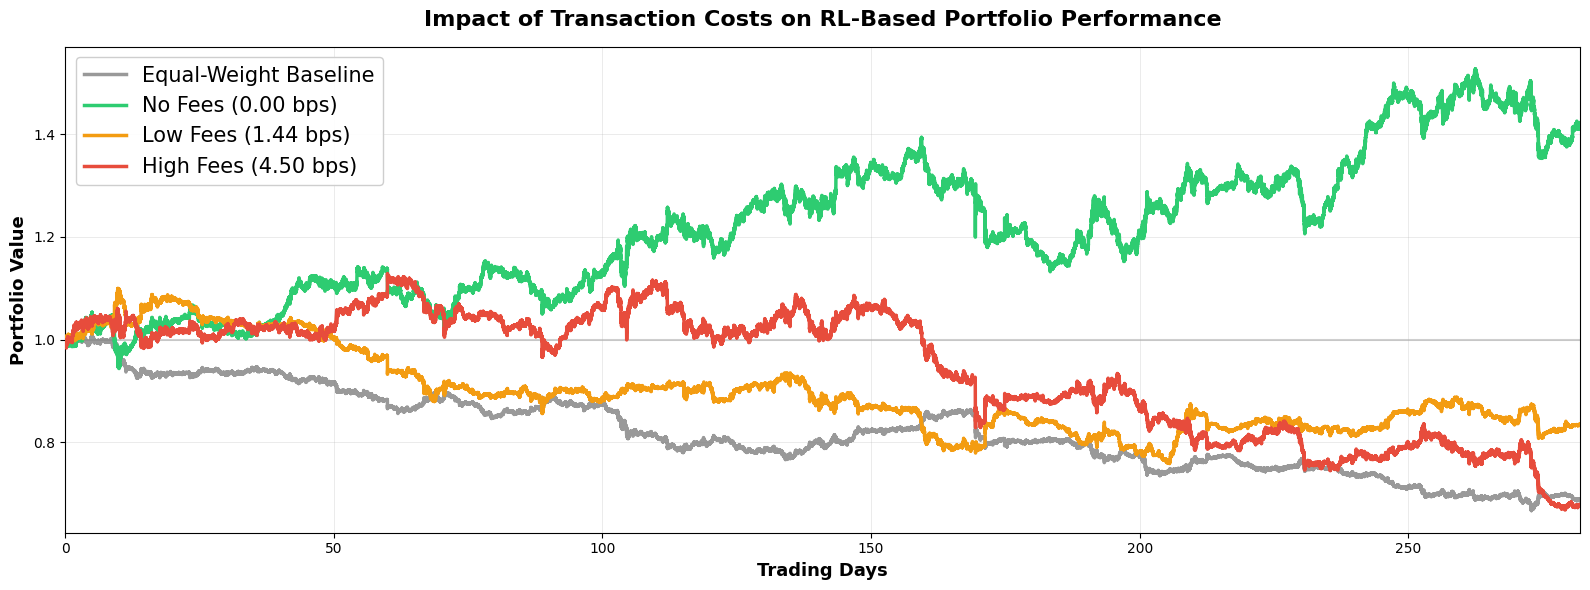

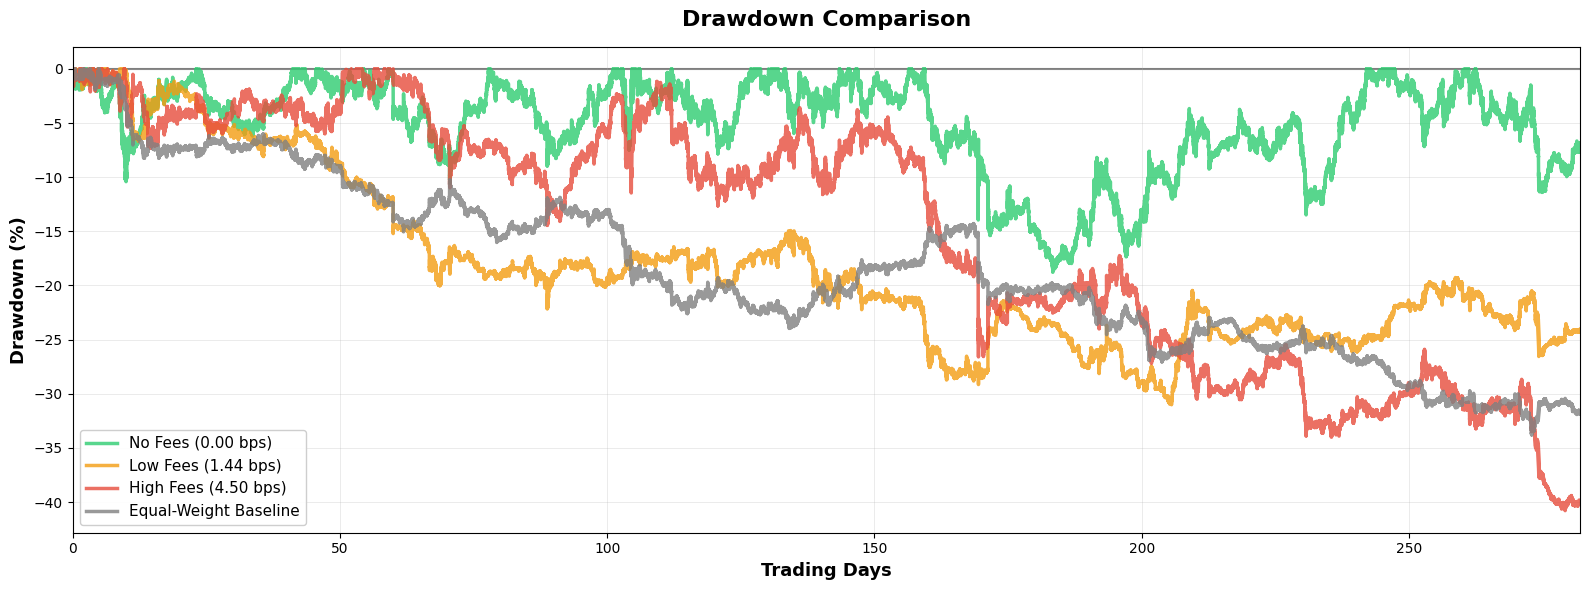

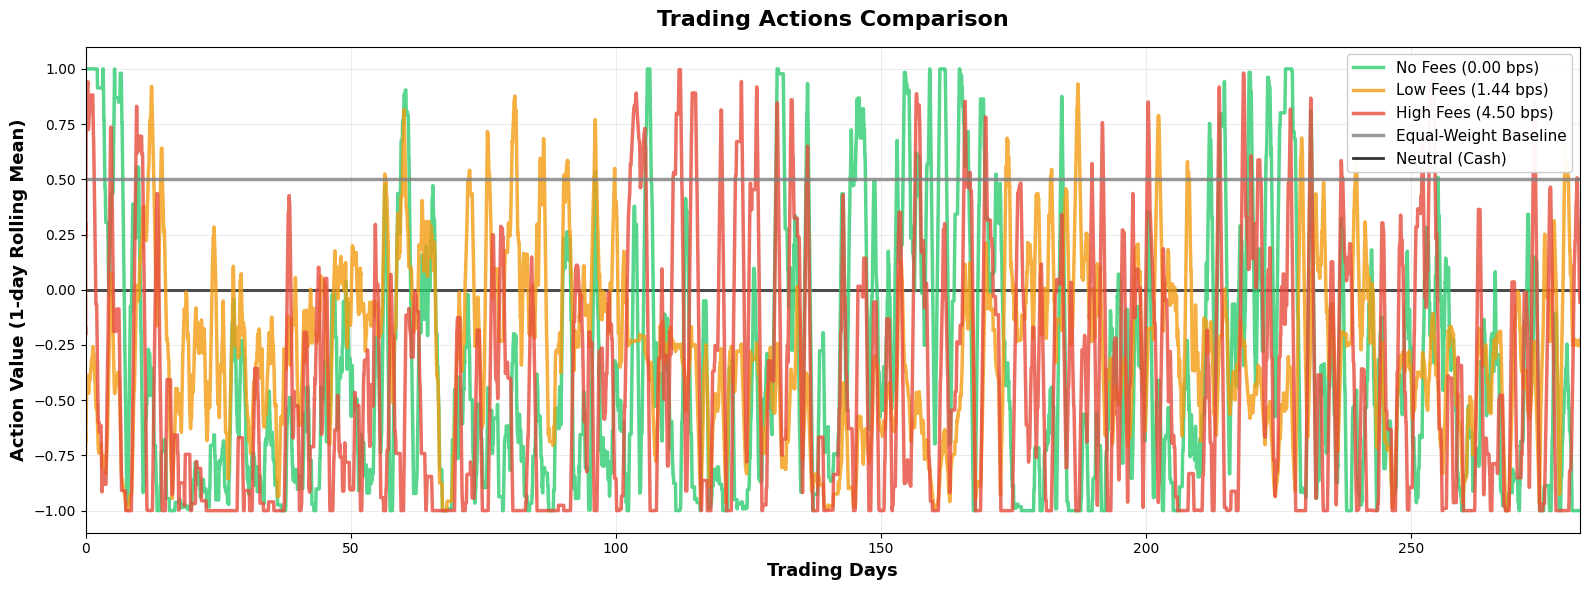


✓ Multi-model comparison visualization complete!


In [80]:
# ========================================
# COMPREHENSIVE VISUALIZATION: ALL MODELS
# ========================================

# Output settings - choose format: 'pdf', 'svg', 'png' (high-dpi), or None to skip saving
SAVE_FORMAT = 'pdf'  # Options: 'pdf', 'svg', 'png', None
SAVE_DPI = 300  # DPI for PNG (ignored for vector formats)
PLOTS_DIR = CONFIG["EVAL"]["reports_dir"]
ensure_dir(PLOTS_DIR)

# Convert steps to days
days = np.arange(len(all_results[0]["equity_curve"])) / minutes_per_day

# Rolling window: 1 trading day
rolling_window = int(1 * minutes_per_day)

# Helper function to save figures
def save_figure(fig, name, fmt=SAVE_FORMAT, dpi=SAVE_DPI):
    if fmt is None:
        return
    filepath = os.path.join(PLOTS_DIR, f"{name}.{fmt}")
    if fmt == 'pdf':
        fig.savefig(filepath, format='pdf', bbox_inches='tight', dpi=dpi)
    elif fmt == 'svg':
        fig.savefig(filepath, format='svg', bbox_inches='tight')
    elif fmt == 'png':
        fig.savefig(filepath, format='png', bbox_inches='tight', dpi=dpi)
    print(f"   Saved: {filepath}")

# ===== PLOT 1: Portfolio Value - All Models vs Baseline =====
fig1, ax = plt.subplots(figsize=(16, 6))

# Plot baseline first (in background)
ax.plot(
    days[:len(baseline_result["equity_curve"])],
    baseline_result["equity_curve"].values,
    label=baseline_result["model_name"],
    color=baseline_result["color"],
    linestyle=baseline_result["linestyle"],
    linewidth=2.5,
    alpha=0.8,
    zorder=2
)

# Plot all RL models
for result in all_results:
    ax.plot(
        days[:len(result["equity_curve"])],
        result["equity_curve"].values,
        label=f'{result["model_name"]} ({result["fee_bps"]:.2f} bps)',
        color=result["color"],
        linestyle=result["linestyle"],
        linewidth=2.5,
        zorder=3
    )

# Reference line at initial value
ax.axhline(y=1.0, color='#888888', linestyle='-', linewidth=1.5, alpha=0.4, zorder=1)

ax.set_title('Impact of Transaction Costs on RL-Based Portfolio Performance',
             fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Trading Days', fontsize=13, fontweight='600')
ax.set_ylabel('Portfolio Value', fontsize=13, fontweight='600')
ax.legend(fontsize=15, loc='best', framealpha=0.95)
ax.grid(True, alpha=0.25, linestyle='-', linewidth=0.7)
ax.set_xlim(0, total_days)

plt.tight_layout()
plt.savefig(
    'rl_test_performance.pdf',
    format='pdf',
    bbox_inches='tight'
)
plt.show()
plt.close(fig1)

# ===== PLOT 2: Drawdown Comparison =====
fig2, ax = plt.subplots(figsize=(16, 6))

# Plot drawdowns
for result in all_results:
    ec = result["equity_curve"]
    drawdown = (ec / ec.cummax() - 1) * 100  # Convert to percentage
    ax.plot(
        days[:len(drawdown)],
        drawdown.values,
        label=f'{result["model_name"]} ({result["fee_bps"]:.2f} bps)',
        color=result["color"],
        linestyle=result["linestyle"],
        linewidth=2.5,
        alpha=0.8
    )

# Baseline drawdown
ec_bench = baseline_result["equity_curve"]
bench_drawdown = (ec_bench / ec_bench.cummax() - 1) * 100
ax.plot(
    days[:len(bench_drawdown)],
    bench_drawdown.values,
    label=baseline_result["model_name"],
    color=baseline_result["color"],
    linestyle=baseline_result["linestyle"],
    linewidth=2.5,
    alpha=0.8
)

ax.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.5, zorder=1)
ax.set_title('Drawdown Comparison', fontsize=16, fontweight='bold', pad=15)
ax.set_xlabel('Trading Days', fontsize=13, fontweight='600')
ax.set_ylabel('Drawdown (%)', fontsize=13, fontweight='600')
ax.legend(fontsize=11, loc='best', framealpha=0.95)
ax.grid(True, alpha=0.25, linestyle='-', linewidth=0.7)
ax.set_xlim(0, total_days)

plt.tight_layout()
plt.show()
plt.close(fig2)

# ===== PLOT 3: Actions Comparison (Rolling Mean) =====
fig3, ax = plt.subplots(figsize=(16, 6))

for result in all_results:
    act = result["actions"]
    act_rolling = act.rolling(window=rolling_window, min_periods=1).mean()
    
    days_act = np.arange(len(act)) / minutes_per_day
    
    ax.plot(
        days_act,
        act_rolling.values,
        label=f'{result["model_name"]} ({result["fee_bps"]:.2f} bps)',
        color=result["color"],
        linestyle=result["linestyle"],
        linewidth=2.5,
        alpha=0.8
    )

# Add baseline (constant line)
ax.axhline(
    y=baseline_result["action_mean"],
    color=baseline_result["color"],
    linestyle=baseline_result["linestyle"],
    linewidth=2.5,
    alpha=0.8,
    label=baseline_result["model_name"]
)

# Zero line
ax.axhline(y=0, color='black', linestyle='-', linewidth=2.0, alpha=0.8, 
           label='Neutral (Cash)', zorder=1)

ax.set_xlabel('Trading Days', fontsize=13, fontweight='600')
ax.set_ylabel('Action Value (1-day Rolling Mean)', fontsize=13, fontweight='600')
ax.set_title('Trading Actions Comparison', fontsize=16, fontweight='bold', pad=15)
ax.legend(fontsize=11, loc='best', framealpha=0.95)
ax.grid(True, alpha=0.25, linestyle='-', linewidth=0.7)
ax.set_xlim(0, total_days)
ax.set_ylim(-1.1, 1.1)

plt.tight_layout()
plt.show()
plt.close(fig3)

print("\n✓ Multi-model comparison visualization complete!")

In [81]:
# ========================================
# SUMMARY STATISTICS TABLE
# ========================================

print("\n" + "="*80)
print("SUMMARY: KEY METRICS")
print("="*80)

summary_data = []

for result in all_results:
    summary_data.append({
        "Model": result["model_name"],
        "Fees": f"{result['fee_bps']:.2f} bps",
        "Return": f"{result['total_return']:.2f}%",
        "CAGR": f"{result['cagr']:.2f}%",
        "Sharpe": f"{result['sharpe']:.3f}",
        "Max DD": f"{result['max_drawdown']:.2f}%",
        "Volatility": f"{result['volatility']:.2f}%",
        "Turnover/Day": f"{result['avg_turnover_per_day']:.3f}"
    })

# Add baseline
summary_data.append({
    "Model": baseline_result["model_name"],
    "Fees": f"{baseline_result['fee_bps']:.2f} bps",
    "Return": f"{baseline_result['total_return']:.2f}%",
    "CAGR": f"{baseline_result['cagr']:.2f}%",
    "Sharpe": f"{baseline_result['sharpe']:.3f}",
    "Max DD": f"{baseline_result['max_drawdown']:.2f}%",
    "Volatility": f"{baseline_result['volatility']:.2f}%",
    "Turnover/Day": f"{baseline_result['avg_turnover_per_day']:.3f}"
})

df_summary = pd.DataFrame(summary_data)
print("\n")
print(df_summary.to_string(index=False))
print("\n" + "="*80)

# ========================================
# ACTION STATISTICS TABLE
# ========================================

print("\n" + "="*80)
print("ACTION METRICS")
print("="*80)

action_data = []

for result in all_results:
    action_data.append({
        "Model": result["model_name"],
        "Fees": f"{result['fee_bps']:.2f} bps",
        "Mean Action": f"{result['action_mean']:.3f}",
        "Std Action": f"{result['action_std']:.3f}",
        "Min Action": f"{result['action_min']:.3f}",
        "Max Action": f"{result['action_max']:.3f}",
        "Total Turnover": f"{result['total_turnover']:.2f}",
        "Avg Turnover/Day": f"{result['avg_turnover_per_day']:.3f}"
    })

# Add baseline
action_data.append({
    "Model": baseline_result["model_name"],
    "Fees": f"{baseline_result['fee_bps']:.2f} bps",
    "Mean Action": f"{baseline_result['action_mean']:.3f}",
    "Std Action": f"{baseline_result['action_std']:.3f}",
    "Min Action": f"{baseline_result['action_min']:.3f}",
    "Max Action": f"{baseline_result['action_max']:.3f}",
    "Total Turnover": f"{baseline_result['total_turnover']:.2f}",
    "Avg Turnover/Day": f"{baseline_result['avg_turnover_per_day']:.3f}"
})

df_actions = pd.DataFrame(action_data)
print("\n")
print(df_actions.to_string(index=False))
print("\n" + "="*80)


SUMMARY: KEY METRICS


                Model     Fees  Return    CAGR Sharpe  Max DD Volatility Turnover/Day
              No Fees 0.00 bps  42.20%  57.74%  1.430 -18.78%     36.54%       18.378
             Low Fees 1.44 bps -16.49% -20.80% -0.855 -31.01%     23.92%       14.121
            High Fees 4.50 bps -32.37% -39.73% -1.301 -40.79%     34.37%        6.689
Equal-Weight Baseline 0.00 bps -31.29% -38.47% -2.564 -33.81%     18.29%        0.000


ACTION METRICS


                Model     Fees Mean Action Std Action Min Action Max Action Total Turnover Avg Turnover/Day
              No Fees 0.00 bps      -0.376      0.926     -1.000      1.000        5181.90           18.378
             Low Fees 1.44 bps      -0.277      0.605     -1.000      1.000        3981.56           14.121
            High Fees 4.50 bps      -0.435      0.835     -1.000      1.000        1886.15            6.689
Equal-Weight Baseline 0.00 bps       0.500      0.000      0.500      0.500           0.00     

In [82]:
# ========================================
# SAVE RESULTS TO FILE
# ========================================

from datetime import datetime
import json

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Ensure reports directory exists
reports_dir = CONFIG.get("EVAL", {}).get("reports_dir", "./reports")
os.makedirs(reports_dir, exist_ok=True)

# Save comparison table
csv_path = os.path.join(reports_dir, f"multi_model_comparison_{timestamp}.csv")
df_comparison.to_csv(csv_path, index=False)
print(f"\n✅ Saved comparison table to: {csv_path}")

# Save detailed results as JSON
json_results = []
for result in all_results + [baseline_result]:
    json_results.append({
        "model_name": result["model_name"],
        "fee_bps": result["fee_bps"],
        "performance": {
            "final_value": float(result["final_value"]),
            "total_return": float(result["total_return"]),
            "cagr": float(result["cagr"]),
            "sharpe": float(result["sharpe"]),
            "sortino": float(result["sortino"]),
            "calmar": float(result["calmar"]),
            "max_drawdown": float(result["max_drawdown"]),
            "volatility": float(result["volatility"]),
            "hit_ratio": float(result["hit_ratio"])
        },
        "actions": {
            "mean": float(result["action_mean"]),
            "std": float(result["action_std"]),
            "min": float(result["action_min"]),
            "max": float(result["action_max"]),
            "total_turnover": float(result["total_turnover"]),
            "avg_turnover_per_day": float(result["avg_turnover_per_day"])
        }
    })

json_path = os.path.join(reports_dir, f"multi_model_comparison_{timestamp}.json")
with open(json_path, "w") as f:
    json.dump(json_results, f, indent=2)
print(f"✅ Saved detailed results to: {json_path}")

print(f"\n{'='*80}")
print("ALL RESULTS SAVED SUCCESSFULLY")
print(f"{'='*80}")


✅ Saved comparison table to: ./reports/multi_model_comparison_20260107_121553.csv
✅ Saved detailed results to: ./reports/multi_model_comparison_20260107_121553.json

ALL RESULTS SAVED SUCCESSFULLY
